In [11]:
#Absraction
import numpy as np
import itertools
from collections import defaultdict


class RobotAbstraction:
    def __init__(self, state_intervals, control_values, perturbation, delta_t):
        self.state_intervals = state_intervals  # [(x_min, x_max), (y_min, y_max), (theta_min, theta_max)]
        self.control_values = control_values  # [(v_min, v_max), (omega_min, omega_max)]
        self.perturbation = perturbation  # [(w1_min, w1_max), (w2_min, w2_max), (w3_min, w3_max)]
        self.delta_t = delta_t  # sampling time (time to change a state) = 1s
        self.state_to_index = {"OutOfGrid": -1}  # Map from state tuple to symbolic state ξ
        self.index_to_intervals = {}  # Map from symbolic state ξ to intervals
        self.state_edges = []  
        self.discrete_x_y=20
        self.discrete_tetha=10
        self.v_vals=3
        self.omega_vals=5
        self._create_state_mapping()  # Precompute the symbolic state mapping
        self.compute_transitions_dict() 
    def get_successors(self, state_idx, action):
        """
        Return list of successor state indices from `state_idx` under `action`.
        Requires that `compute_transitions()` has been called and stored in `self.transitions_dict`.
        """
        if not hasattr(self, 'transitions_dict'):
            raise AttributeError(
                "Transitions not computed. Call `robot.compute_transitions_dict()` first."
            )
        action_key = tuple(np.round(action, decimals=5))  # Avoid floating-point key issues
        return list(self.transitions_dict.get((state_idx, action_key), set()))
    def compute_transitions_dict(self):
        """
        Compute and store transitions as a dictionary: {(state, action): set(successors)}
        """
        transitions = self.compute_transitions()  # Uses your existing method
        self.transitions_dict = {}
        for state, control, successors in transitions:
            control_key = tuple(np.round(control, decimals=5))
            self.transitions_dict[(state, control_key)] = successors

    def _create_state_mapping(self):
        """Precompute a mapping from discrete states to symbolic indices (ξ) and intervals."""
        self.state_edges = [
            np.linspace(interval[0], interval[1], self.discrete_x_y) for interval in self.state_intervals[:2]
        ]
        self.state_edges.append(
            np.linspace(self.state_intervals[2][0], self.state_intervals[2][1], self.discrete_tetha)
        )

        state_grid = np.array(np.meshgrid(*[edges[:-1] for edges in self.state_edges])).T.reshape(-1, 3)

        for idx, state in enumerate(state_grid, start=1):
            discrete_state = tuple(
                np.digitize(state[i], self.state_edges[i]) for i in range(len(state))
            )

            self.state_to_index[discrete_state] = idx

            # Map intervals for each dimension of the state
            intervals = []
            for i, edge in enumerate(self.state_edges):
                low = edge[discrete_state[i] - 1]
                high = edge[discrete_state[i]]
                intervals.append((low, high))
            self.index_to_intervals[idx] = intervals
    def dynamics(self, x_center, u, w_center, D_x, D_w):
        """Modified system dynamics based on the image formula."""
        nominal_dynamics = np.array([
            x_center[0] + self.delta_t * (u[0] * np.cos(x_center[2]) + w_center[0]),
            x_center[1] + self.delta_t * (u[0] * np.sin(x_center[2]) + w_center[1]),
            x_center[2] + self.delta_t * (u[1] + w_center[2])
        ])
        delta_x = np.array([5/99, 5/99, np.pi /30 ])   # delta x = (x max-x min)/Nx-1  chosen randomly
        delta_w = np.array([0.025, 0.025, 0.025])

        correction = (
            nominal_dynamics - D_x @ delta_x - D_w @ delta_w,
            nominal_dynamics + D_x @ delta_x + D_w @ delta_w
        )
        return correction


    def compute_Dx_and_Dw(self, u):
        """Compute the bounds matrices D_x and D_w."""
        D_x = np.array([
            [1, 0, self.delta_t * 0.25],
            [0, 1, self.delta_t * 0.25],
            [0, 0, 1]
        ])
        D_w = np.array([
            [self.delta_t, 0, 0],
            [0, self.delta_t, 0],
            [0, 0, self.delta_t]
        ])
        return D_x, D_w
    

    def _find_state(self, x):   
        """Find the discrete state corresponding to x. x is a vector =[x,y,theta]."""
        discrete_state = tuple(
            min(np.digitize(x[i], self.state_edges[i]), len(self.state_edges[i]) - 1)
            for i in range(len(x))
        )
        return self.state_to_index.get(discrete_state, -1)

        



    def compute_transitions(self):
        """Compute transitions for the discrete model, considering perturbations."""
        transitions = []
        state_midpoints = [
            np.linspace(interval[0], interval[1], self.discrete_x_y-1) for interval in self.state_intervals[:2]
        ]
        state_midpoints.append(
            np.linspace(self.state_intervals[2][0], self.state_intervals[2][1], self.discrete_tetha-1)
        )
        state_grid = np.array(np.meshgrid(*state_midpoints)).T.reshape(-1, 3)

        v_vals = np.linspace(self.control_values[0][0], self.control_values[0][1], self.v_vals)
        omega_vals = np.linspace(self.control_values[1][0], self.control_values[1][1], self.omega_vals)
        control_grid = np.array(np.meshgrid(v_vals, omega_vals)).T.reshape(-1, 2)   #All possible control inputs

        for i, state in enumerate(state_grid, start=1):
            for control in control_grid:
                successors = set()  #to keep track of successors of x_center=current state 
                x_center = state
                w_center = np.zeros(3)  # Using zeros for perturbation center
                D_x, D_w = self.compute_Dx_and_Dw(control)
                x_next_lower, x_next_upper = self.dynamics(x_center, control, w_center, D_x, D_w)

                # Compute the Cartesian product of all possible values
                possible_states = itertools.product(
                    np.linspace(x_next_lower[0], x_next_upper[0], 3),
                    np.linspace(x_next_lower[1], x_next_upper[1], 3),
                    np.linspace(x_next_lower[2], x_next_upper[2], 3)
                )

                for possible_state in possible_states:
                    state_idx = self._find_state(possible_state)
                    if state_idx != -1:
                        successors.add(state_idx)
                    else:
                        successors.add(-1)

                transitions.append((i, tuple(control), successors))
        return transitions





    def print_transitions_and_intervals(self, transitions):
        """Print the transitions and intervals for each state."""
        # Group transitions by state
        grouped_transitions = defaultdict(list)
        for state, control, successors in transitions:
            grouped_transitions[state].append((control, successors))

        # Print the grouped transitions
        print("Transitions with Intervals:")
        for state, transitions in grouped_transitions.items():
            if state not in self.index_to_intervals:
                print(f"State ξ={state} not in index_to_intervals! Skipping.")
                continue
            intervals = self.index_to_intervals[state]
            interval_str = ", ".join([f"[{low:.2f}, {high:.2f}]" for low, high in intervals])
            print(f"\nState ξ={state} ({interval_str}):")

            for control, successors in transitions:
                control_str = f"(v={control[0]:.2f}, ω={control[1]:.2f})"
                successors_str = ", ".join([f"ξ={s}" for s in successors]) if successors else "None"
                print(f"  Control {control_str} -> Successors: {successors_str}")




    def find_indices_for_interval(self, interval):
        """
        Find all indices whose intervals overlap with the given interval.

        Args:
            interval: List of tuples [(x_min, x_max), (y_min, y_max), (theta_min, theta_max)]
                     representing the interval to search.

        Returns:
            A list of indices (ξ) that overlap with the given interval.
        """
        overlapping_indices = []

        for index, intervals in self.index_to_intervals.items():
            # Check if all dimensions overlap
            overlap = True
            for dim in range(len(interval)):
                if not (interval[dim][1] >= intervals[dim][0] and interval[dim][0] <= intervals[dim][1]):
                    overlap = False
                    break
            if overlap:
                overlapping_indices.append(index)

        return overlapping_indices
    




class SymbolicControllerSynthesis:
    def __init__(self, transitions, safety_states):
        """
        Initialize the symbolic controller synthesis.

        Parameters:
        - transitions: List of transitions in the form [(state, control, successors), ...].
        - safety_states: Set of safe states (Q_s).
        """
        self.transitions = self._process_transitions(transitions)  # Convert list to dictionary
        self.safety_states = safety_states

    def _process_transitions(self, transitions):
        """
        Convert the list of transitions into a dictionary format.

        Parameters:
        - transitions: List of transitions [(state, control, successors), ...].

        Returns:
        - A dictionary mapping (state, control) -> set(successors).
        """
        transition_dict = defaultdict(set)
        for state, control, successors in transitions:
            transition_dict[(state, control)] = successors
        return dict(transition_dict)

    def pre(self, R):
        """
        Compute the predecessor operator Pre(R), considering only states with valid transitions.

        Parameters:
        - R: Set of states (current safe set).

        Returns:
        - Set of states that can transition to R.
        """
        pre_states = set()
        for (state, control), successors in self.transitions.items():
            # Check if any successor is in R
            if successors and successors.issubset(R):
                pre_states.add(state)
        return pre_states

    def compute_safe_controller(self):
        """
        Compute the maximal safe set (R*).

        Returns:
        - R*: Maximal set of safe states.
        """
        R = self.safety_states.copy()
        Q_s = R
        while True:
            R_next = Q_s.intersection(self.pre(R))
            if R_next == R:
                break
            R = R_next
        return R
    


    def synthesize_controller(self):
        """
        Synthesize a safe controller.

        Returns:
        - R*: Maximal safe set.
        - Controller: Mapping from states to safe controls.
        - Q_0: Set of valid initial states.
        """
        R_star = self.compute_safe_controller()
        controller = defaultdict(set)
        Q_0 = set()

        for (state, control), successors in self.transitions.items():
            # Add controls only if all successors are in R*
            if state in R_star and successors.issubset(R_star):
                controller[state].add(control)

        # Q_0: States in R_star with at least one valid control
        for state in R_star:
            if state in controller:
                Q_0.add(state)

        return R_star, controller, Q_0




In [12]:
#Concretization of Controller

In [13]:
def symbolic_to_continuous_map(state, control):
    """
    Map a symbolic control to its corresponding continuous control.

    Parameters:
    - state: The symbolic state index.
    - control: The symbolic control (tuple of discretized control values).

    Returns:
    - The corresponding continuous control (v, ω).
    """
    
    return control


def concretize_controller_with_intervals(controller, index_to_intervals):
    """
    Concretize the symbolic controller to work with continuous dynamics and include state intervals.
    
    Parameters:
    - controller: Dictionary {state: set of symbolic controls}.
    - index_to_intervals: Dictionary {state: intervals}.
    
    Returns:
    - concretized_controller: Dictionary {state: (intervals, continuous controls)}.
    """
    concretized_controller = {}
    for state, controls in controller.items():
        state_intervals = index_to_intervals.get(state, "No intervals available")
        continuous_controls = {symbolic_to_continuous_map(state, control) for control in controls}
        concretized_controller[state] = (state_intervals, continuous_controls)
    return concretized_controller

In [14]:
#Simulate the optimal ^path using BFS

from collections import deque

import random
import numpy as np

def generate_safe_trajectory(
    initial_state, initial_perturbation, concretized_controller, robot, max_steps=1000
):
    """
    Generate trajectory that never goes out of bounds or reaches state -1.
    """
    def normalize_angle(angle):
        return (angle + np.pi) % (2 * np.pi) - np.pi
    
    def clip_to_bounds(state, robot):
        """Clip state to stay strictly within grid."""
        epsilon = 1e-6
        clipped = state.copy()
        clipped[0] = np.clip(state[0], 
                            robot.state_intervals[0][0] + epsilon,
                            robot.state_intervals[0][1] - epsilon)
        clipped[1] = np.clip(state[1],
                            robot.state_intervals[1][0] + epsilon,
                            robot.state_intervals[1][1] - epsilon)
        clipped[2] = normalize_angle(state[2])
        return clipped
    
    def is_within_bounds(state, robot):
        """Check if state is within bounds (3D: x, y, theta)."""
        return (robot.state_intervals[0][0] <= state[0] <= robot.state_intervals[0][1] and
                robot.state_intervals[1][0] <= state[1] <= robot.state_intervals[1][1] and
                robot.state_intervals[2][0] <= state[2] <= robot.state_intervals[2][1])
    
    # Ensure initial state is within bounds
    current_state = clip_to_bounds(initial_state, robot)
    trajectory = [current_state.tolist()]
    current_perturbation = initial_perturbation
    
    print(f"\nStarting trajectory generation from: {current_state}")
    
    for step in range(max_steps):
        discrete_state = robot._find_state(current_state)
        
        # Stop if we reach invalid state
        if discrete_state == -1:
            print(f"Step {step}: Reached invalid state -1. Stopping.")
            break
        
        if discrete_state not in concretized_controller:
            print(f"Step {step}: No controller for state {discrete_state}. Stopping.")
            break
        
        state_intervals, available_controls = concretized_controller[discrete_state]
        
        if not available_controls:
            print(f"Step {step}: No available controls. Stopping.")
            break
        
        # Try all controls to find one that keeps us in bounds
        controls_list = list(available_controls)
        random.shuffle(controls_list)
        
        success = False
        best_candidate = None
        best_discrete = -1
        
        for control in controls_list:
            # Compute dynamics
            D_x, D_w = robot.compute_Dx_and_Dw(control)
            lower, upper = robot.dynamics(current_state, control, current_perturbation, D_x, D_w)
            
            # Clip the reachable set to grid bounds FIRST
            lower_clipped = clip_to_bounds(lower, robot)
            upper_clipped = clip_to_bounds(upper, robot)
            
            # Try multiple samples from the reachable set
            for attempt in range(15):
                if attempt == 0:
                    # Try center first
                    candidate = (lower_clipped + upper_clipped) / 2
                elif attempt < 5:
                    # Try biased towards staying in bounds
                    alpha = 0.3 + 0.1 * attempt  # 0.3, 0.4, 0.5, 0.6, 0.7
                    candidate = alpha * lower_clipped + (1 - alpha) * upper_clipped
                else:
                    # Random sample
                    candidate = np.array([
                        np.random.uniform(lower_clipped[0], upper_clipped[0]),
                        np.random.uniform(lower_clipped[1], upper_clipped[1]),
                        np.random.uniform(lower_clipped[2], upper_clipped[2])
                    ])
                
                # Ensure it's clipped
                candidate = clip_to_bounds(candidate, robot)
                
                # Double-check bounds
                if not is_within_bounds(candidate, robot):
                    continue
                
                # Check if valid
                next_discrete = robot._find_state(candidate)
                
                # Ensure next state is NOT -1 and is in controller
                if next_discrete != -1 and next_discrete in concretized_controller:
                    best_candidate = candidate
                    best_discrete = next_discrete
                    success = True
                    break
            
            if success:
                break
        
        if success and best_candidate is not None:
            current_state = best_candidate
            trajectory.append(best_candidate.tolist())
        else:
            print(f"Step {step}: Could not find safe next state. Stopping.")
            print(f"  Current state: {current_state}")
            print(f"  Discrete state: {discrete_state}")
            print(f"  Available controls: {len(available_controls)}")
            break
    
    print(f"\n Trajectory generated: {len(trajectory)} states, {len(trajectory)-1} steps")
    
    # Verify no states map to -1
    invalid_states = []
    oob_states = []
    
    for i, s in enumerate(trajectory):
        s_array = np.array(s)
        discrete = robot._find_state(s_array)
        if discrete == -1:
            invalid_states.append((i, s))
        if not is_within_bounds(s_array, robot):
            oob_states.append((i, s))
    
    if invalid_states:
        print(f"   WARNING: {len(invalid_states)} states map to -1!")
        for i, s in invalid_states[:3]:
            print(f"    Step {i}: {s}")
    else:
        print(f"   All states are valid (no -1)")
    
    if oob_states:
        print(f"  WARNING: {len(oob_states)} states out of bounds!")
        for i, s in oob_states[:3]:
            print(f"    Step {i}: {s}")
    else:
        print(f"   All states within bounds")
    
    return trajectory


def select_initial_state_from_Q0_safe(Q_0, robot):
    """
    Select a valid continuous initial state from Q_0, ensuring it's not -1.
    """
    if not Q_0:
        raise ValueError("No valid initial states in Q_0!")
    
    # Remove -1 if it somehow got in
    Q_0_clean = Q_0 - {-1}
    
    if not Q_0_clean:
        raise ValueError("Q_0 only contains invalid state -1!")
    
    # Select a random valid state
    initial_symbolic_state = random.choice(list(Q_0_clean))
    
    # Get the intervals for this symbolic state
    if initial_symbolic_state not in robot.index_to_intervals:
        raise ValueError(f"State {initial_symbolic_state} not in index_to_intervals!")
    
    state_intervals = robot.index_to_intervals[initial_symbolic_state]
    
    # Choose the center point
    continuous_state = np.array([
        (state_intervals[0][0] + state_intervals[0][1]) / 2,
        (state_intervals[1][0] + state_intervals[1][1]) / 2,
        (state_intervals[2][0] + state_intervals[2][1]) / 2
    ])
    
    print(f"\nInitial State Selection:")
    print(f"  Symbolic state ξ={initial_symbolic_state}")
    print(f"  Intervals: {state_intervals}")
    print(f"  Continuous state: [{continuous_state[0]:.3f}, {continuous_state[1]:.3f}, {continuous_state[2]:.3f}]")
    
    return continuous_state, initial_symbolic_state




def compute_transitions_safe(self):
    """
    Compute transitions, excluding -1 and clipping to bounds.
    """
    transitions = []
    state_midpoints = [
        np.linspace(interval[0], interval[1], self.discrete_x_y-1) 
        for interval in self.state_intervals[:2]
    ]
    state_midpoints.append(
        np.linspace(self.state_intervals[2][0], self.state_intervals[2][1], 
                   self.discrete_tetha-1)
    )
    state_grid = np.array(np.meshgrid(*state_midpoints)).T.reshape(-1, 3)

    v_vals = np.linspace(self.control_values[0][0], self.control_values[0][1], self.v_vals)
    omega_vals = np.linspace(self.control_values[1][0], self.control_values[1][1], self.omega_vals)
    control_grid = np.array(np.meshgrid(v_vals, omega_vals)).T.reshape(-1, 2)

    out_of_bounds_count = 0
    
    for i, state in enumerate(state_grid, start=1):
        for control in control_grid:
            successors = set()
            x_center = state
            w_center = np.zeros(3)
            D_x, D_w = self.compute_Dx_and_Dw(control)
            x_next_lower, x_next_upper = self.dynamics(x_center, control, w_center, D_x, D_w)
            
            # CLIP to grid bounds (x, y, theta)
            x_next_lower[0] = max(x_next_lower[0], self.state_intervals[0][0])
            x_next_lower[1] = max(x_next_lower[1], self.state_intervals[1][0])
            x_next_lower[2] = max(x_next_lower[2], self.state_intervals[2][0])
            x_next_upper[0] = min(x_next_upper[0], self.state_intervals[0][1])
            x_next_upper[1] = min(x_next_upper[1], self.state_intervals[1][1])
            x_next_upper[2] = min(x_next_upper[2], self.state_intervals[2][1])

            # Compute the Cartesian product
            possible_states = itertools.product(
                np.linspace(x_next_lower[0], x_next_upper[0], 3),
                np.linspace(x_next_lower[1], x_next_upper[1], 3),
                np.linspace(x_next_lower[2], x_next_upper[2], 3)
            )

            for possible_state in possible_states:
                state_idx = self._find_state(possible_state)
                
                # NEVER add -1
                if state_idx != -1:
                    successors.add(state_idx)
                else:
                    out_of_bounds_count += 1

            # Only add if has valid successors
            if successors:
                transitions.append((i, tuple(control), successors))
    
    print(f"Transition computation: {len(transitions)} valid transitions, {out_of_bounds_count} OOB rejected")
    return transitions


RobotAbstraction.compute_transitions_safe = compute_transitions_safe






In [15]:
#Robot Model
state_intervals = [(0, 10), (0, 10), (-np.pi, np.pi)]  # x, y, theta ranges
perturbation = [(-0.05, 0.05), (-0.05, 0.05), (-np.pi, np.pi)]  # Perturbation ranges
control_values = [(0.25,1), (-1, 1)]  # Linear and angular velocity ranges
delta_t = 1 # Time step

#Abstraction

robot = RobotAbstraction(state_intervals, control_values, perturbation, delta_t)
transitions = robot.compute_transitions()
robot.print_transitions_and_intervals(transitions)

Transitions with Intervals:

State ξ=1 ([0.00, 0.53], [0.00, 0.53], [-3.14, -2.44]):
  Control (v=0.25, ω=-1.00) -> Successors: ξ=-1
  Control (v=0.25, ω=-0.50) -> Successors: ξ=-1
  Control (v=0.25, ω=0.00) -> Successors: ξ=-1
  Control (v=0.25, ω=0.50) -> Successors: ξ=-1
  Control (v=0.25, ω=1.00) -> Successors: ξ=-1
  Control (v=0.62, ω=-1.00) -> Successors: ξ=-1
  Control (v=0.62, ω=-0.50) -> Successors: ξ=-1
  Control (v=0.62, ω=0.00) -> Successors: ξ=-1
  Control (v=0.62, ω=0.50) -> Successors: ξ=-1
  Control (v=0.62, ω=1.00) -> Successors: ξ=-1
  Control (v=1.00, ω=-1.00) -> Successors: ξ=-1
  Control (v=1.00, ω=-0.50) -> Successors: ξ=-1
  Control (v=1.00, ω=0.00) -> Successors: ξ=-1
  Control (v=1.00, ω=0.50) -> Successors: ξ=-1
  Control (v=1.00, ω=1.00) -> Successors: ξ=-1

State ξ=2 ([0.00, 0.53], [0.53, 1.05], [-3.14, -2.44]):
  Control (v=0.25, ω=-1.00) -> Successors: ξ=-1
  Control (v=0.25, ω=-0.50) -> Successors: ξ=-1
  Control (v=0.25, ω=0.00) -> Successors: ξ=-1
  Co

C:\Users\RPC\AppData\Local\Temp\ipykernel_23712\4293780800.py:216: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  cell_rect = plt.Rectangle((cell_x - dx_cell/2, cell_y - dy_cell/2),


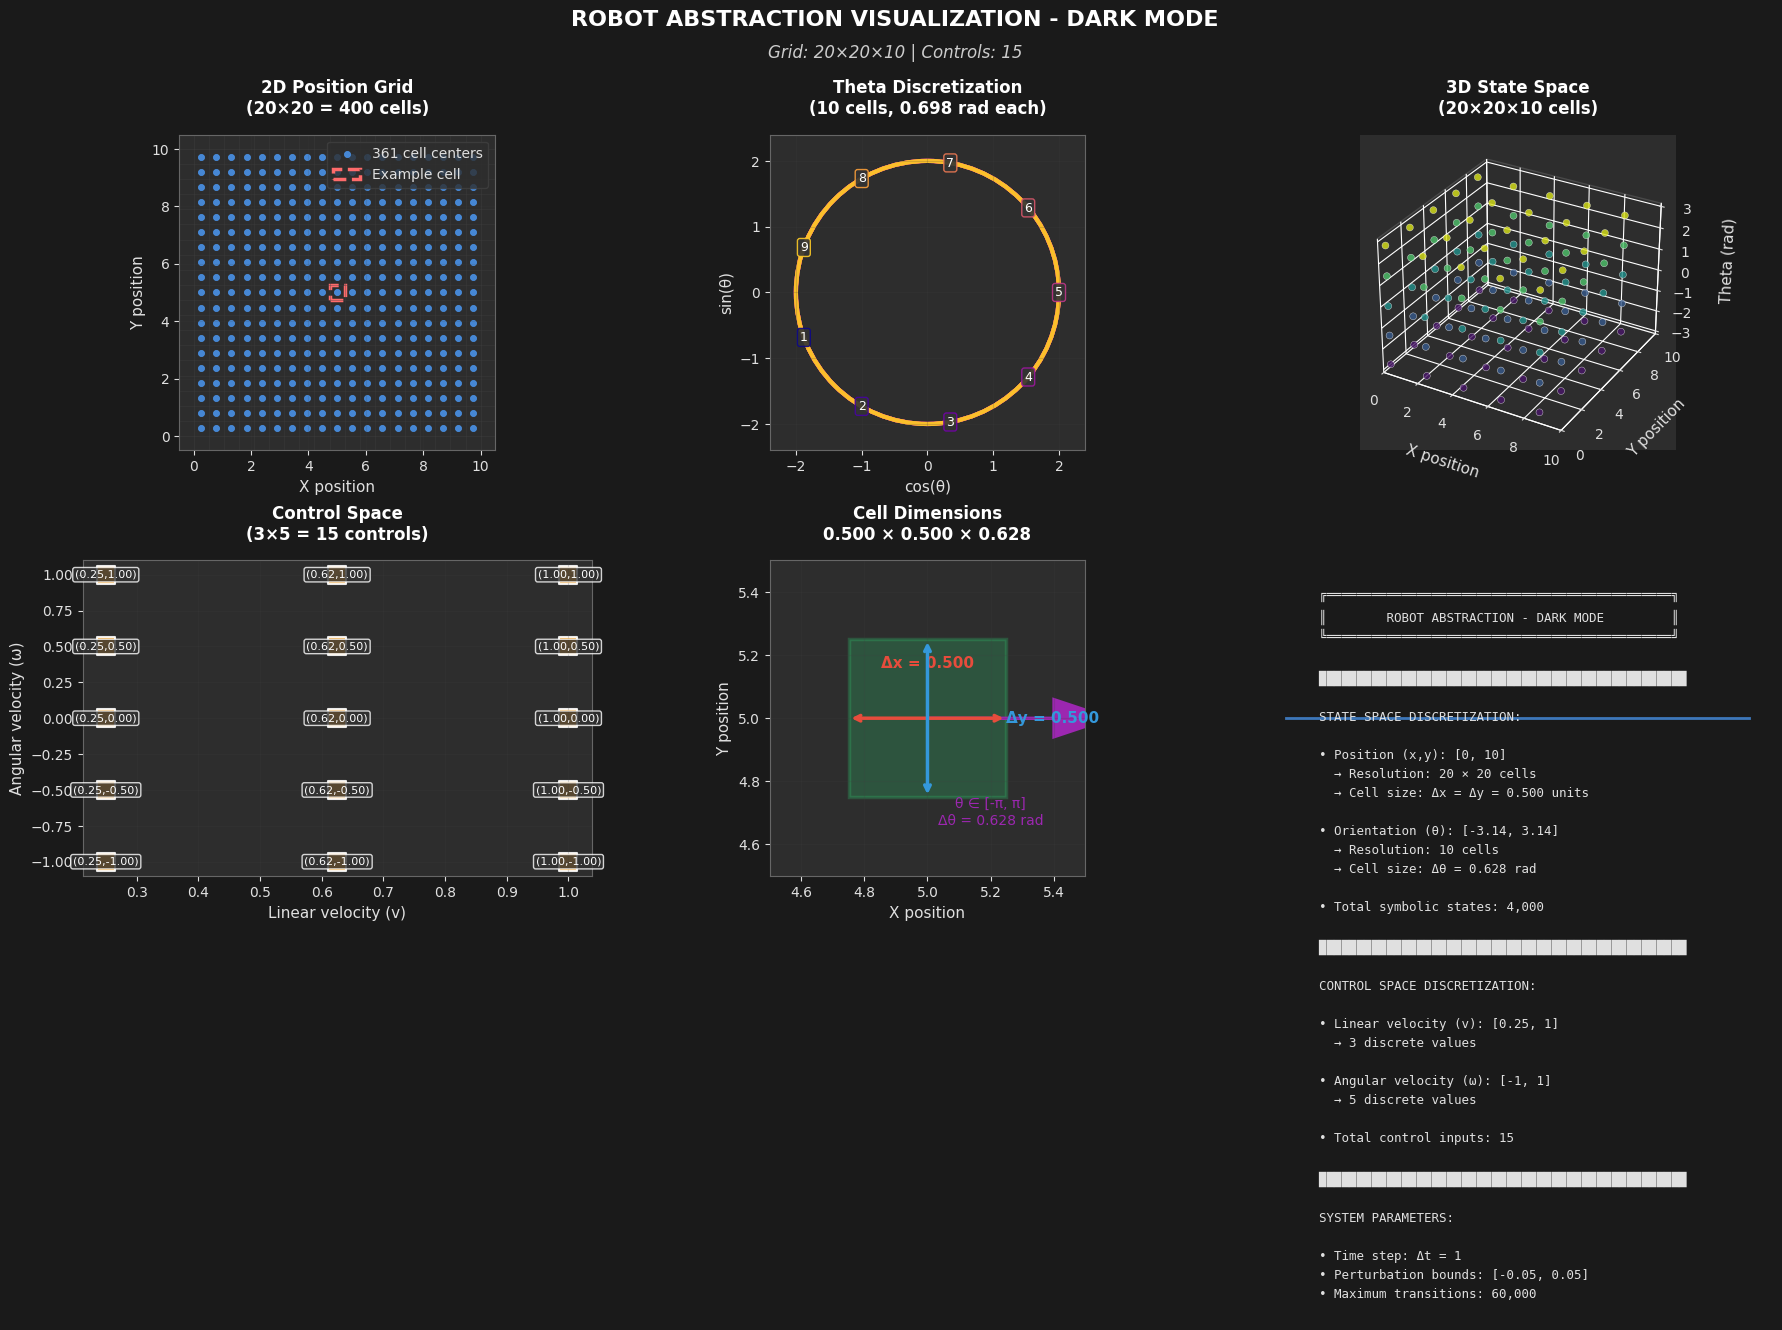


ROBOT ABSTRACTION - DISCRETIZATION SUMMARY
Position discretization: 20×20 cells
  → Cell size: 0.500 × 0.500 units
Orientation discretization: 10 cells
  → Cell size: 0.628 rad (36.0°)
Total symbolic states: 4,000
Total control inputs: 15


In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def plot_discretization_grid_dark(robot):
    """
    Plot the discretization grid of the robot abstraction in dark mode.
    
    Args:
        robot: RobotAbstraction object
    """
    # Set dark theme
    plt.style.use('dark_background')
    
    # Create figure with dark background
    fig = plt.figure(figsize=(18, 12), facecolor='#1a1a1a')
    
    # Custom color palette for dark mode
    colors = {
        'grid': '#404040',
        'cell_center': '#4d9fff',  # Bright blue
        'highlight': '#ff6b6b',    # Coral red
        'text': '#e0e0e0',
        'title': '#ffffff',
        'axes': '#666666',
        'background': '#2d2d2d',
        'control': '#ffa726',      # Orange
        'theta': '#9c27b0',        # Purple
        'info_bg': '#2a2a2a'
    }
    
    # Plot 1: 2D grid (x, y) - showing all cells
    ax1 = fig.add_subplot(231, facecolor=colors['background'])
    
    # Get grid edges from robot object
    x_edges = robot.state_edges[0]
    y_edges = robot.state_edges[1]
    
    # Plot grid lines (creates 20×20 grid)
    for x in x_edges:
        ax1.axvline(x, color=colors['grid'], alpha=0.5, linestyle='-', linewidth=0.5)
    for y in y_edges:
        ax1.axhline(y, color=colors['grid'], alpha=0.5, linestyle='-', linewidth=0.5)
    
    # Plot cell centers
    x_centers = (x_edges[:-1] + x_edges[1:]) / 2
    y_centers = (y_edges[:-1] + y_edges[1:]) / 2
    X_centers, Y_centers = np.meshgrid(x_centers, y_centers)
    
    # Plot all 400 centers with glow effect
    scatter1 = ax1.scatter(X_centers.flatten(), Y_centers.flatten(), s=20, 
                          color=colors['cell_center'], alpha=0.8, 
                          label=f'{len(x_centers)*len(y_centers)} cell centers',
                          edgecolors=colors['cell_center'], linewidth=0.5)
    
    # Highlight one cell
    sample_i, sample_j = len(x_centers)//2, len(y_centers)//2
    cell_x_min = x_edges[sample_i]
    cell_x_max = x_edges[sample_i + 1]
    cell_y_min = y_edges[sample_j]
    cell_y_max = y_edges[sample_j + 1]
    
    # Draw highlighted cell with neon effect
    rect = plt.Rectangle((cell_x_min, cell_y_min), 
                        cell_x_max - cell_x_min, 
                        cell_y_max - cell_y_min,
                        fill=False, edgecolor=colors['highlight'], linewidth=2.5, 
                        linestyle='--', label='Example cell')
    ax1.add_patch(rect)
    
    # Style axes
    ax1.set_xlabel('X position', color=colors['text'], fontsize=11)
    ax1.set_ylabel('Y position', color=colors['text'], fontsize=11)
    ax1.set_title(f'2D Position Grid\n({robot.discrete_x_y}×{robot.discrete_x_y} = {robot.discrete_x_y**2} cells)', 
                 color=colors['title'], fontsize=12, fontweight='bold', pad=15)
    ax1.set_xlim(-0.5, 10.5)
    ax1.set_ylim(-0.5, 10.5)
    ax1.set_aspect('equal')
    ax1.grid(True, alpha=0.15, color=colors['grid'])
    ax1.tick_params(colors=colors['text'])
    ax1.spines['bottom'].set_color(colors['axes'])
    ax1.spines['top'].set_color(colors['axes'])
    ax1.spines['left'].set_color(colors['axes'])
    ax1.spines['right'].set_color(colors['axes'])
    ax1.legend(loc='upper right', facecolor=colors['background'], 
               edgecolor=colors['grid'], labelcolor=colors['text'])
    
    # Plot 2: Theta discretization
    ax2 = fig.add_subplot(232, facecolor=colors['background'])
    
    theta_edges = robot.state_edges[2]
    theta_centers = (theta_edges[:-1] + theta_edges[1:]) / 2
    theta_widths = np.diff(theta_edges)
    
    # Create circular representation with glow
    circle_radius = 2
    for i, (center, width) in enumerate(zip(theta_centers, theta_widths)):
        # Color based on theta value
        color = plt.cm.plasma(i/len(theta_centers))
        arc = plt.Circle((0, 0), circle_radius, fill=False, 
                        color=color, linewidth=3, alpha=0.8)
        ax2.add_patch(arc)
        
        # Add label
        label_x = circle_radius * np.cos(center)
        label_y = circle_radius * np.sin(center)
        ax2.text(label_x, label_y, f'{i+1}', 
                fontsize=9, ha='center', va='center', color='white',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='#333333', 
                         edgecolor=color, alpha=0.9))
    
    ax2.set_xlabel('cos(θ)', color=colors['text'], fontsize=11)
    ax2.set_ylabel('sin(θ)', color=colors['text'], fontsize=11)
    ax2.set_title(f'Theta Discretization\n({robot.discrete_tetha} cells, {theta_widths[0]:.3f} rad each)', 
                 color=colors['title'], fontsize=12, fontweight='bold', pad=15)
    ax2.set_xlim(-circle_radius*1.2, circle_radius*1.2)
    ax2.set_ylim(-circle_radius*1.2, circle_radius*1.2)
    ax2.set_aspect('equal')
    ax2.grid(True, alpha=0.2, color=colors['grid'])
    ax2.tick_params(colors=colors['text'])
    ax2.spines['bottom'].set_color(colors['axes'])
    ax2.spines['top'].set_color(colors['axes'])
    ax2.spines['left'].set_color(colors['axes'])
    ax2.spines['right'].set_color(colors['axes'])
    
    # Plot 3: Complete 3D state space
    ax3 = fig.add_subplot(233, projection='3d', facecolor=colors['background'])
    
    # Sample points
    x_sample_indices = np.arange(0, len(x_centers), 4)
    y_sample_indices = np.arange(0, len(y_centers), 4)
    theta_sample_indices = np.arange(0, len(theta_centers), 2)
    
    X_sample = x_centers[x_sample_indices]
    Y_sample = y_centers[y_sample_indices]
    Theta_sample = theta_centers[theta_sample_indices]
    
    X, Y, Theta = np.meshgrid(X_sample, Y_sample, Theta_sample)
    
    # Color by theta value using viridis colormap
    colors_3d = plt.cm.viridis((Theta.flatten() + np.pi) / (2 * np.pi))
    
    scatter3 = ax3.scatter(X.flatten(), Y.flatten(), Theta.flatten(),
                          c=colors_3d, s=25, alpha=0.8, 
                          edgecolors='white', linewidth=0.3)
    
    # Style 3D plot
    ax3.set_xlabel('X position', color=colors['text'], fontsize=11, labelpad=10)
    ax3.set_ylabel('Y position', color=colors['text'], fontsize=11, labelpad=10)
    ax3.set_zlabel('Theta (rad)', color=colors['text'], fontsize=11, labelpad=10)
    ax3.set_title(f'3D State Space\n({robot.discrete_x_y}×{robot.discrete_x_y}×{robot.discrete_tetha} cells)', 
                 color=colors['title'], fontsize=12, fontweight='bold', pad=15)
    ax3.set_xlim(0, 10)
    ax3.set_ylim(0, 10)
    ax3.set_zlim(-np.pi, np.pi)
    ax3.xaxis.pane.fill = False
    ax3.yaxis.pane.fill = False
    ax3.zaxis.pane.fill = False
    ax3.xaxis.pane.set_edgecolor(colors['axes'])
    ax3.yaxis.pane.set_edgecolor(colors['axes'])
    ax3.zaxis.pane.set_edgecolor(colors['axes'])
    ax3.xaxis.label.set_color(colors['text'])
    ax3.yaxis.label.set_color(colors['text'])
    ax3.zaxis.label.set_color(colors['text'])
    ax3.tick_params(colors=colors['text'])
    ax3.grid(True, alpha=0.15, color=colors['grid'])
    
    # Plot 4: Control discretization
    ax4 = fig.add_subplot(234, facecolor=colors['background'])
    
    # Get control values
    v_min, v_max = robot.control_values[0]
    omega_min, omega_max = robot.control_values[1]
    v_vals = np.linspace(v_min, v_max, robot.v_vals)
    omega_vals = np.linspace(omega_min, omega_max, robot.omega_vals)
    
    # Create control grid
    V, Omega = np.meshgrid(v_vals, omega_vals)
    
    # Plot control points with glow
    sc4 = ax4.scatter(V.flatten(), Omega.flatten(), 
                     s=150, c=colors['control'], alpha=0.9, marker='s',
                     edgecolors='white', linewidth=1.5)
    
    # Label each control point
    for i in range(len(v_vals)):
        for j in range(len(omega_vals)):
            ax4.text(v_vals[i], omega_vals[j], 
                    f'({v_vals[i]:.2f},{omega_vals[j]:.2f})', 
                    fontsize=8, ha='center', va='center', color='white',
                    bbox=dict(boxstyle='round,pad=0.2', facecolor='#333333', alpha=0.8))
    
    ax4.set_xlabel('Linear velocity (v)', color=colors['text'], fontsize=11)
    ax4.set_ylabel('Angular velocity (ω)', color=colors['text'], fontsize=11)
    ax4.set_title(f'Control Space\n({robot.v_vals}×{robot.omega_vals} = {robot.v_vals * robot.omega_vals} controls)', 
                 color=colors['title'], fontsize=12, fontweight='bold', pad=15)
    ax4.grid(True, alpha=0.2, color=colors['grid'])
    ax4.tick_params(colors=colors['text'])
    ax4.spines['bottom'].set_color(colors['axes'])
    ax4.spines['top'].set_color(colors['axes'])
    ax4.spines['left'].set_color(colors['axes'])
    ax4.spines['right'].set_color(colors['axes'])
    
    # Plot 5: Detailed cell dimensions
    ax5 = fig.add_subplot(235, facecolor=colors['background'])
    
    # Calculate cell dimensions
    dx_cell = 10 / robot.discrete_x_y
    dy_cell = 10 / robot.discrete_x_y
    dtheta_cell = (2 * np.pi) / robot.discrete_tetha
    
    # Draw detailed cell
    cell_x = 5
    cell_y = 5
    
    cell_rect = plt.Rectangle((cell_x - dx_cell/2, cell_y - dy_cell/2),
                             dx_cell, dy_cell,
                             fill=True, alpha=0.25, color='#2ecc71',
                             edgecolor='#27ae60', linewidth=2.5)
    ax5.add_patch(cell_rect)
    
    # Add dimension arrows
    ax5.annotate('', xy=(cell_x - dx_cell/2, cell_y), 
                xytext=(cell_x + dx_cell/2, cell_y),
                arrowprops=dict(arrowstyle='<->', color='#e74c3c', lw=2.5))
    ax5.text(cell_x, cell_y + 0.15, f'Δx = {dx_cell:.3f}', 
            ha='center', va='bottom', fontsize=11, color='#e74c3c', fontweight='bold')
    
    ax5.annotate('', xy=(cell_x, cell_y - dy_cell/2), 
                xytext=(cell_x, cell_y + dy_cell/2),
                arrowprops=dict(arrowstyle='<->', color='#3498db', lw=2.5))
    ax5.text(cell_x + 0.25, cell_y, f'Δy = {dy_cell:.3f}', 
            ha='left', va='center', fontsize=11, color='#3498db', fontweight='bold')
    
    # Orientation arrow
    theta_arrow_length = min(dx_cell, dy_cell) * 0.8
    ax5.arrow(cell_x, cell_y, 
              theta_arrow_length * np.cos(0),
              theta_arrow_length * np.sin(0),
              head_width=0.12, head_length=0.18, 
              fc=colors['theta'], ec=colors['theta'], linewidth=2)
    
    ax5.text(cell_x + theta_arrow_length/2, cell_y - 0.25, 
             f'θ ∈ [-π, π]\nΔθ = {dtheta_cell:.3f} rad', 
             ha='center', va='top', fontsize=10, color=colors['theta'])
    
    ax5.set_xlim(cell_x - dx_cell, cell_x + dx_cell)
    ax5.set_ylim(cell_y - dy_cell, cell_y + dy_cell)
    ax5.set_xlabel('X position', color=colors['text'], fontsize=11)
    ax5.set_ylabel('Y position', color=colors['text'], fontsize=11)
    ax5.set_title(f'Cell Dimensions\n{dx_cell:.3f} × {dy_cell:.3f} × {dtheta_cell:.3f}', 
                 color=colors['title'], fontsize=12, fontweight='bold', pad=15)
    ax5.set_aspect('equal')
    ax5.grid(True, alpha=0.2, color=colors['grid'])
    ax5.tick_params(colors=colors['text'])
    ax5.spines['bottom'].set_color(colors['axes'])
    ax5.spines['top'].set_color(colors['axes'])
    ax5.spines['left'].set_color(colors['axes'])
    ax5.spines['right'].set_color(colors['axes'])
    
    # Plot 6: Statistics and information
    ax6 = fig.add_subplot(236, facecolor=colors['info_bg'])
    ax6.axis('off')
    
    # Calculate statistics
    total_states = robot.discrete_x_y**2 * robot.discrete_tetha
    total_controls = robot.v_vals * robot.omega_vals
    
    # Create information text with monospace font and spacing
    info_text = f"""
    ╔══════════════════════════════════════════════╗
    ║        ROBOT ABSTRACTION - DARK MODE         ║
    ╚══════════════════════════════════════════════╝
    
    █████████████████████████████████████████████████
    
    STATE SPACE DISCRETIZATION:
    
    • Position (x,y): [{state_intervals[0][0]}, {state_intervals[0][1]}]
      → Resolution: {robot.discrete_x_y} × {robot.discrete_x_y} cells
      → Cell size: Δx = Δy = {dx_cell:.3f} units
    
    • Orientation (θ): [{state_intervals[2][0]:.2f}, {state_intervals[2][1]:.2f}]
      → Resolution: {robot.discrete_tetha} cells
      → Cell size: Δθ = {dtheta_cell:.3f} rad
    
    • Total symbolic states: {total_states:,}
    
    █████████████████████████████████████████████████
    
    CONTROL SPACE DISCRETIZATION:
    
    • Linear velocity (v): [{v_min}, {v_max}]
      → {robot.v_vals} discrete values
    
    • Angular velocity (ω): [{omega_min}, {omega_max}]
      → {robot.omega_vals} discrete values
    
    • Total control inputs: {total_controls}
    
    █████████████████████████████████████████████████
    
    SYSTEM PARAMETERS:
    
    • Time step: Δt = {robot.delta_t}
    • Perturbation bounds: [{robot.perturbation[0][0]}, {robot.perturbation[0][1]}]
    • Maximum transitions: {total_states * total_controls:,}
    """
    
    # Add text with proper formatting
    ax6.text(0.05, 0.97, info_text, fontsize=9, verticalalignment='top',
            fontfamily='DejaVu Sans Mono', linespacing=1.6,
            color=colors['text'], transform=ax6.transAxes)
    
    # Add a decorative line
    ax6.plot([0.05, 0.95], [0.92, 0.92], color='#4d9fff', linewidth=2, alpha=0.7)
    
    # Main title with glowing effect
    plt.suptitle(f'ROBOT ABSTRACTION VISUALIZATION - DARK MODE', 
                fontsize=16, fontweight='bold', color='#ffffff',
                y=1.02, fontfamily='DejaVu Sans')
    
    # Subtitle
    fig.text(0.5, 0.98, f'Grid: {robot.discrete_x_y}×{robot.discrete_x_y}×{robot.discrete_tetha} | Controls: {total_controls}', 
            ha='center', fontsize=12, color='#cccccc', fontstyle='italic')
    
    plt.tight_layout()
    
    # Save option with dark background
    # plt.savefig('robot_abstraction_dark.png', dpi=150, facecolor='#1a1a1a', bbox_inches='tight')
    
    plt.show()
    
    # Print console output with colors (for terminals that support it)
    print("\n" + "="*70)
    print("\033[1;36m" + "ROBOT ABSTRACTION - DISCRETIZATION SUMMARY" + "\033[0m")
    print("="*70)
    print(f"\033[1;33mPosition discretization:\033[0m {robot.discrete_x_y}×{robot.discrete_x_y} cells")
    print(f"  → Cell size: \033[1;32m{dx_cell:.3f} × {dy_cell:.3f} units\033[0m")
    print(f"\033[1;33mOrientation discretization:\033[0m {robot.discrete_tetha} cells")
    print(f"  → Cell size: \033[1;35m{dtheta_cell:.3f} rad\033[0m (\033[1;35m{np.degrees(dtheta_cell):.1f}°\033[0m)")
    print(f"\033[1;33mTotal symbolic states:\033[0m \033[1;36m{total_states:,}\033[0m")
    print(f"\033[1;33mTotal control inputs:\033[0m \033[1;36m{total_controls}\033[0m")
    print("="*70)

# Run the dark mode visualization
plot_discretization_grid_dark(robot)

# SYMBOLIC CONTROLLER SYNTHESIS (OBJECTIF 2) 

In [17]:
# Step 1: Extract states and transitions dynamically from the abstraction
states = list(robot.state_to_index.values())  # Get all states from the abstraction
transitions = [
    (state, control, successors)
    for state, control, successors in robot.compute_transitions_safe()
]  # Transitions directly from the abstraction phase (using safe version)




# CORRECTED: Exclude states in region R4 AND exclude -1 from safety states
search_interval = [(4, 6), (6, 8), (-np.pi, np.pi)]  # Interval of interest

# Get the overlapping indices for R4
R4_bounds = robot.find_indices_for_interval(search_interval)

def is_state_in_R4(state, R4_bounds):
    """
    Check if the state intervals overlap with the R4 bounds.
    """
    if state in R4_bounds:
        return True
    return False

# CORRECTED: Explicitly exclude -1 (OutOfGrid) from safety states
safety_states = set([
    state for state in states 
    if state != -1 and not is_state_in_R4(state, R4_bounds)
])



# Step 2: Initialize and synthesize the controller
controller_synthesis = SymbolicControllerSynthesis(
    transitions=transitions,
    safety_states=safety_states,
)

R_star, controller, Q_0 = controller_synthesis.synthesize_controller()

# Step 3: Print results
print("\nSafe States (R*):", R_star)
print("\nInitial States (Q_0):", Q_0)
print("\nSynthesized Controller:")
for state, controls in controller.items():
    # Format controls to 2 decimal places
    formatted_controls = [
        f"({x:.2f}, {y:.2f})" for x, y in controls
    ]
    print(f"State ξ={state} -> Controls: {', '.join(formatted_controls)}")



# CONCRETIZE CONTROLLER

concretized_controller_with_intervals = concretize_controller_with_intervals(
    controller=controller,  # Synthesized symbolic controller
    index_to_intervals=robot.index_to_intervals  # State intervals from the abstraction
)

# Print concretized controls with intervals
print("Concretized Controller with State Intervals:")
for state, (intervals, controls) in concretized_controller_with_intervals.items():
    print(f"State ξ={state}:")
    print(f"  Intervals: {intervals}")
    # Format controls to 2 decimal places
    formatted_controls = [
        f"({x:.2f}, {y:.2f})" for x, y in controls
    ]
    print(f"  Continuous Controls: {', '.join(formatted_controls)}")


Transition computation: 48735 valid transitions, 102402 OOB rejected

Safe States (R*): {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 226, 227, 228, 229,

In [18]:
#just test added 16/11

# Select initial state (function is defined in Cell 4)
valid_initial_state, initial_symbolic_state = select_initial_state_from_Q0_safe(Q_0, robot)

# Set Initial Perturbation
initial_perturbation = np.array([0.0, 0.0, 0.0])  # Start with no perturbation

# Generate the trajectory
trajectory = generate_safe_trajectory(
    initial_state=valid_initial_state,
    initial_perturbation=initial_perturbation,
    concretized_controller=concretized_controller_with_intervals,
    robot=robot,
    max_steps=1000
)

# Print the trajectory
print("\nGenerated Trajectory:")
for step, state in enumerate(trajectory):
    print(f"Step {step}: {state}")



def select_specific_initial_state(Q_0, robot, preference="random"):
    """
    Select initial state with different strategies.
    
    Parameters:
    - preference: "random", "closest_to_origin", "first", or specific index
    """
    if not Q_0:
        raise ValueError("No valid initial states in Q_0!")
    
    Q_0_list = list(Q_0)
    
    if preference == "random":
        initial_symbolic_state = random.choice(Q_0_list)
    elif preference == "first":
        initial_symbolic_state = Q_0_list[0]
    elif preference == "closest_to_origin":
        # Find state closest to origin (0, 0)
        min_dist = float('inf')
        best_state = None
        for state in Q_0_list:
            intervals = robot.index_to_intervals[state]
            center_x = (intervals[0][0] + intervals[0][1]) / 2
            center_y = (intervals[1][0] + intervals[1][1]) / 2
            dist = np.sqrt(center_x**2 + center_y**2)
            if dist < min_dist:
                min_dist = dist
                best_state = state
        initial_symbolic_state = best_state
    elif isinstance(preference, int) and preference in Q_0:
        initial_symbolic_state = preference
    else:
        initial_symbolic_state = Q_0_list[0]
    
    state_intervals = robot.index_to_intervals[initial_symbolic_state]
    continuous_state = np.array([
        (state_intervals[0][0] + state_intervals[0][1]) / 2,
        (state_intervals[1][0] + state_intervals[1][1]) / 2,
        (state_intervals[2][0] + state_intervals[2][1]) / 2
    ])
    
    return continuous_state, initial_symbolic_state




def validate_initial_state(state, Q_0, robot):
    """
    Verify that a continuous state corresponds to a symbolic state in Q_0.
    """
    discrete_state = robot._find_state(state)
    if discrete_state not in Q_0:
        raise ValueError(f"State {state} (symbolic: {discrete_state}) is not in Q_0!")
    print(f"Initial state validated: symbolic state {discrete_state} is in Q_0")
    return True

# After selecting initial state:
validate_initial_state(valid_initial_state, Q_0, robot)


Initial State Selection:
  Symbolic state ξ=1937
  Intervals: [(np.float64(3.1578947368421053), np.float64(3.6842105263157894)), (np.float64(8.947368421052632), np.float64(9.473684210526315)), (np.float64(0.34906585039886595), np.float64(1.0471975511965974))]
  Continuous state: [3.421, 9.211, 0.698]

Starting trajectory generation from: [3.42105263 9.21052632 0.6981317 ]
Step 125: Could not find safe next state. Stopping.
  Current state: [4.06067602 5.70517748 1.81157291]
  Discrete state: 2671
  Available controls: 10

 Trajectory generated: 126 states, 125 steps
   All states are valid (no -1)
   All states within bounds

Generated Trajectory:
Step 0: [3.4210526315789473, 9.210526315789473, 0.6981317007977319]
Step 1: [3.612563742358692, 9.371223218211107, -0.3018682992022681]
Step 2: [4.2093029310836325, 9.185407878048084, 0.6981317007977319]
Step 3: [4.688080708032993, 9.58715013410217, 0.1981317007977319]
Step 4: [5.668516748929307, 9.7839880616252, -0.3018682992022681]
Step 5:

True

In [19]:
# Set Initial Perturbation
import numpy as np
initial_perturbation = np.array([0.0, 0.0, 0.0])  # Start with no perturbation
valid_initial_state = np.array([0,1,0])
# Generate the trajectory
trajectory = generate_safe_trajectory(
    initial_state=valid_initial_state,
    initial_perturbation=initial_perturbation,
    concretized_controller=concretized_controller_with_intervals,
    robot=robot,
    max_steps=1000
)

# Print the trajectory
print("\nGenerated Trajectory:")
for step, state in enumerate(trajectory):
    print(f"Step {step}: {state}")


Starting trajectory generation from: [0 1 0]
Step 302: Could not find safe next state. Stopping.
  Current state: [ 3.67023519  7.76227004 -1.07121462]
  Discrete state: 851
  Available controls: 15

 Trajectory generated: 303 states, 302 steps
   All states are valid (no -1)
   All states within bounds

Generated Trajectory:
Step 0: [0, 1, 0]
Step 1: [0.625, 1.0, -0.5]
Step 2: [1.5025825618903728, 0.520574461395797, -1.0]
Step 3: [2.0428848677585125, 1e-06, -0.5]
Step 4: [2.5913739689399957, 1e-06, 0.0]
Step 5: [2.8413739689399957, 0.05084349464248272, 0.0]
Step 6: [3.8413739689399957, 0.07626474196372408, 1.0]
Step 7: [3.976449545407031, 0.2866324881656982, 0.5]
Step 8: [4.854032107297404, 0.7660580267699012, -0.5]
Step 9: [5.073427747769998, 0.6462016421188505, 0.0]
Step 10: [5.323427747769998, 0.6462016421188505, -1.0]
Step 11: [5.661116688937585, 0.1202822766139151, -0.5]
Step 12: [6.538699250827958, 1e-06, 0.0]
Step 13: [7.163699250827958, 0.05084349464248272, -1.0]
Step 14: [7.

=== SYMBOLIC CONTROLLER WITH MATPLOTLIB VISUALIZATION ===

1. Création de l'abstraction du robot...
Transitions: 48735 valid, 102402 OOB rejected
2. Calcul des transitions...
Transitions: 48735 valid, 102402 OOB rejected
États sûrs: 3024
Région R4 (indices): 225
3. Synthèse du contrôleur symbolique...
États sûrs maximaux (R*): 2993
États initiaux valides (Q_0): 2993
4. Sélection de l'état initial...
Initial state: ξ=1651
Continuous: [5.526, 8.684, 0.000]
5. Génération de la trajectoire sûre...
Starting trajectory from: [5.52631579 8.68421053 0.        ]
Trajectory generated: 51 states
Trajectoire générée: 51 points
6. Création de la visualisation...

Choisissez le type de visualisation:
1. Visualisation statique (image PNG)
2. Animation (GIF animé)


Testing Safe Reachability Controller (FAST): Reach R3, Avoid R4
Target region R3 -> 20 states
Unsafe region R4 -> 20 states
Computing safe R* (fast BFS)...
Iteration 1: |R*| = 31
Iteration 2: |R*| = 68
Iteration 3: |R*| = 133
Iteration 4: |R*| = 211
Iteration 5: |R*| = 299
Iteration 6: |R*| = 359
Iteration 7: |R*| = 385
Iteration 8: |R*| = 389
Iteration 9: |R*| = 390
Iteration 10: |R*| = 390
Safe R* done. Total states: 390 (cap 40 iters).
✓ Initial state 163 can safely reach target
Computing safe controller policy...
Policy computed for 390 states.

Starting SAFE simulation...
Step 0: (2.00, 1.00), state 91, SAFE
Step 10: (4.65, 2.83), state 282, SAFE
🎯 TARGET REACHED at step 12!
Simulation done: steps=14 | target=True | violations=0


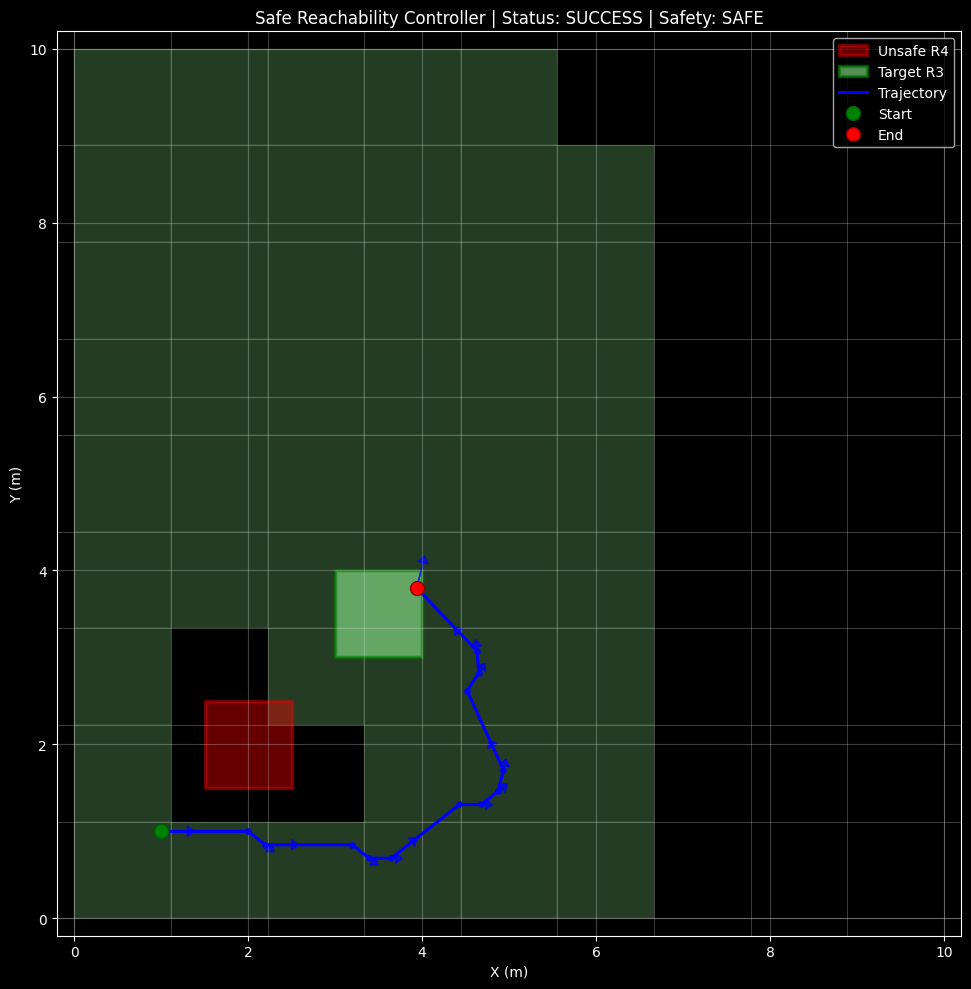


SAFE REACHABILITY ANALYSIS
Safe reachable states (R*): 390
Trajectory steps: 14
Target reached: True
Safety violations: 0
Final position: (3.94, 3.80)
🎯 PERFECT: Target reached with no safety violations!



In [21]:



import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib.patches as patches

class RobotAbstraction:
    def __init__(self, state_intervals, control_values, perturbation, delta_t):
        self.state_intervals = state_intervals
        self.control_values = control_values
        self.perturbation = perturbation
        self.delta_t = delta_t

        # Discretization (10x10x6 = 600 states)
        self.discrete_x_y = 10
        self.discrete_tetha = 6

        # Action sampling (denser for better reachability)
        self.v_vals = 4      # finer linear speed sampling
        self.omega_vals = 7  # finer angular speed sampling

        self.state_to_index = {"OutOfGrid": -1}
        self.index_to_intervals = {}
        self.state_edges = []

        self._create_state_mapping()

    def _create_state_mapping(self):
        self.state_edges = [
            np.linspace(interval[0], interval[1], self.discrete_x_y) for interval in self.state_intervals[:2]
        ]
        self.state_edges.append(
            np.linspace(self.state_intervals[2][0], self.state_intervals[2][1], self.discrete_tetha)
        )

        # fill mapping index -> intervals
        state_grid = np.array(np.meshgrid(*[edges[:-1] for edges in self.state_edges])).T.reshape(-1, 3)
        for idx, state in enumerate(state_grid, start=1):
            discrete_state = tuple(
                np.digitize(state[i], self.state_edges[i]) for i in range(len(state))
            )
            self.state_to_index[discrete_state] = idx
            intervals = []
            for i, edge in enumerate(self.state_edges):
                low = edge[discrete_state[i] - 1]
                high = edge[discrete_state[i]]
                intervals.append((low, high))
            self.index_to_intervals[idx] = intervals

    def compute_Dx_and_Dw(self, u):
        # small linearization buffers used only for over-approximation
        D_x = np.array([
            [1, 0, self.delta_t * 0.25],
            [0, 1, self.delta_t * 0.25],
            [0, 0, 1]
        ])
        D_w = np.array([
            [self.delta_t, 0, 0],
            [0, self.delta_t, 0],
            [0, 0, self.delta_t]
        ])
        return D_x, D_w

    def dynamics(self, x_center, u, w_center, D_x, D_w):
        # nominal dynamics (used in simulation for a more accurate step)
        nominal = np.array([
            x_center[0] + self.delta_t * (u[0] * np.cos(x_center[2]) + w_center[0]),
            x_center[1] + self.delta_t * (u[0] * np.sin(x_center[2]) + w_center[1]),
            x_center[2] + self.delta_t * (u[1] + w_center[2])
        ])

        # conservative buffers (only for reachability over-approximation)
        # reduced slightly to avoid excessive contraction that made the controller stall
        delta_x = np.array([3/99, 3/99, np.pi / 60])
        delta_w = np.array([0.015, 0.015, 0.015])

        low = nominal - D_x @ delta_x - D_w @ delta_w
        up  = nominal + D_x @ delta_x + D_w @ delta_w
        return low, up, nominal

    def _find_state(self, x):
        # wrap theta to [-pi, pi] when mapping
        x = np.array(x, dtype=float)
        x[2] = ((x[2] + np.pi) % (2 * np.pi)) - np.pi
        discrete_state = tuple(
            min(np.digitize(x[i], self.state_edges[i]), len(self.state_edges[i]) - 1)
            for i in range(len(x))
        )
        return self.state_to_index.get(discrete_state, -1)

    def find_indices_for_interval(self, interval):
        overlapping_indices = []
        for index, intervals in self.index_to_intervals.items():
            overlap = True
            for dim in range(len(interval)):
                if not (interval[dim][1] >= intervals[dim][0] and interval[dim][0] <= intervals[dim][1]):
                    overlap = False
                    break
            if overlap:
                overlapping_indices.append(index)
        return overlapping_indices

    def sample_actions(self):
        v_vals = np.linspace(self.control_values[0][0], self.control_values[0][1], self.v_vals)
        omega_vals = np.linspace(self.control_values[1][0], self.control_values[1][1], self.omega_vals)
        return [(float(v), float(om)) for v, om in itertools.product(v_vals, omega_vals)]

    def successors_overapprox(self, state, action, samples=3):
        """Return discrete successor states over-approximated and sampled."""
        if state not in self.index_to_intervals:
            return []
        intervals = self.index_to_intervals[state]
        x_center = (intervals[0][0] + intervals[0][1]) / 2
        y_center = (intervals[1][0] + intervals[1][1]) / 2
        theta_center = (intervals[2][0] + intervals[2][1]) / 2

        w_center = np.zeros(3)
        D_x, D_w = self.compute_Dx_and_Dw(action)
        low, up, _ = self.dynamics(np.array([x_center, y_center, theta_center]),
                                   np.array(action), w_center, D_x, D_w)

        succ = set()
        for i in range(samples):
            for j in range(samples):
                for k in range(samples):
                    ax = i / (samples - 1) if samples > 1 else 0.5
                    ay = j / (samples - 1) if samples > 1 else 0.5
                    at = k / (samples - 1) if samples > 1 else 0.5
                    xs = low[0] + ax * (up[0] - low[0])
                    ys = low[1] + ay * (up[1] - low[1])
                    th = low[2] + at * (up[2] - low[2])
                    sidx = self._find_state(np.array([xs, ys, th]))
                    if sidx != -1:
                        succ.add(sidx)
        return list(succ)


# ==============================================================================
# SAFE REACHABILITY CONTROLLER (FAST BFS VERSION)
# ==============================================================================

class SafeReachabilityController:
    """
    Reach R3 while avoiding R4. Fast version:
    - Precompute successors for all state-action pairs once
    - Backward BFS from target to compute R* and levels
    - Controller picks actions that decrease level and avoid R4
    """
    def __init__(self, robot, target_states, unsafe_states):
        self.robot = robot
        self.target_states = set(target_states)
        self.unsafe_states = set(unsafe_states)
        self.R_star = set()
        self.level = {}   # state -> BFS level (0 for target states)
        self.H = {}       # multivalued safe controller: state -> list of actions

        # Precompute transitions for all states and actions (huge speed-up)
        self.actions = self.robot.sample_actions()
        self.transitions = {}  # (state, action) -> [next_states]
        for state in self.robot.index_to_intervals.keys():
            for a in self.actions:
                # increase samples slightly for better coverage
                self.transitions[(state, a)] = self.robot.successors_overapprox(state, a, samples=3)

    def compute_R_star(self):
        """
        Backward BFS:
        - Start frontier with target_states (level 0)
        - Add states that can reach frontier with a safe action:
          any successor in frontier AND all successors not in R4.
        """
        print("Computing safe R* (fast BFS)...")
        frontier = set(self.target_states)
        self.R_star = set(frontier)
        for s in frontier:
            self.level[s] = 0

        max_iters = 40  # slightly higher cap
        it = 0

        while frontier and it < max_iters:
            it += 1
            new_frontier = set()
            # scan all states; add those that can reach current frontier safely
            for state in self.robot.index_to_intervals.keys():
                if state in self.R_star:  # already in
                    continue
                if state in self.unsafe_states:
                    continue
                # exists a safe action that reaches frontier
                for a in self.actions:
                    succ = self.transitions[(state, a)]
                    if not succ:
                        continue
                    reaches_frontier = any(ns in frontier for ns in succ)
                    avoids_unsafe = all(ns not in self.unsafe_states for ns in succ)
                    if reaches_frontier and avoids_unsafe:
                        self.R_star.add(state)
                        self.level[state] = self._min_level_in(succ, default=it) + 1
                        new_frontier.add(state)
                        break
            frontier = new_frontier
            print(f"Iteration {it}: |R*| = {len(self.R_star)}")

        print(f"Safe R* done. Total states: {len(self.R_star)} (cap {max_iters} iters).")
        return self.R_star

    def _min_level_in(self, states, default=9999):
        vals = [self.level[s] for s in states if s in self.level]
        return min(vals) if vals else default

    def compute_safe_reachability_controller(self):
        """
        For each state in R*, pick actions whose successors:
        - stay out of R4
        - reduce level toward target (prefer lower level)
        Additionally, when multiple actions share the same best level reduction,
        prefer the action that improves geometric progress to the target center.
        """
        if not self.R_star:
            self.compute_R_star()
        print("Computing safe controller policy...")

        # precompute target centers (use mean of R3 intervals in x,y)
        target_center_xy = None

        # If R3 exists, approximate its center using the first state's intervals
        if len(self.target_states) > 0:
            any_target = next(iter(self.target_states))
            xi, yi, _ = self.robot.index_to_intervals[any_target]
            target_center_xy = np.array([(xi[0] + xi[1]) / 2.0, (yi[0] + yi[1]) / 2.0], dtype=float)

        for state in self.R_star:
            valid = []
            best_level = float('inf')
            best_progress = -float('inf')

            # extract a representative continuous state center for evaluating progress
            xi, yi, ti = self.robot.index_to_intervals[state]
            x_center = (xi[0] + xi[1]) / 2.0
            y_center = (yi[0] + yi[1]) / 2.0
            theta_center = (ti[0] + ti[1]) / 2.0
            xyt_center = np.array([x_center, y_center, theta_center], dtype=float)

            for a in self.actions:
                succ = self.transitions[(state, a)]
                if not succ:
                    continue
                avoids_unsafe = all(ns not in self.unsafe_states for ns in succ)
                succ_levels = [self.level.get(ns, float('inf')) for ns in succ]
                min_succ_level = min(succ_levels) if succ_levels else float('inf')

                # evaluate geometric progress (projected step toward target center)
                progress = -float('inf')
                if target_center_xy is not None:
                    # one-step nominal displacement length toward target center
                    # compute nominal next and its improvement in distance
                    w_center = np.zeros(3)
                    D_x, D_w = self.robot.compute_Dx_and_Dw(a)
                    _, _, nominal_next = self.robot.dynamics(xyt_center, np.array(a), w_center, D_x, D_w)
                    curr_dist = np.linalg.norm(target_center_xy - np.array([x_center, y_center]))
                    next_dist = np.linalg.norm(target_center_xy - nominal_next[:2])
                    progress = curr_dist - next_dist  # positive if moving closer

                # choose actions that move closer (lower level) and avoid R4
                if avoids_unsafe and min_succ_level < self.level.get(state, float('inf')):
                    if (min_succ_level < best_level) or (min_succ_level == best_level and progress > best_progress):
                        valid = [a]
                        best_level = min_succ_level
                        best_progress = progress
                    elif min_succ_level == best_level and np.isclose(progress, best_progress, atol=1e-6):
                        valid.append(a)

            self.H[state] = valid
        print(f"Policy computed for {len(self.H)} states.")
        return self.H

    def get_safe_reachability_action(self, continuous_state):
        """
        Pick the first valid action at this discrete state; emergency stop otherwise.
        """
        discrete_state = self.robot._find_state(np.array(continuous_state))
        actions = self.H.get(discrete_state, [])
        if actions:
            return actions[0]
        print(f"⚠️ Warning: No safe action for state {discrete_state}. Emergency stop.")
        return (0.0, 0.0)


# ==============================================================================
# SIMULATION + VISUALIZATION
# ==============================================================================

def is_in_target_region(state, target_bounds):
    x, y, _ = state
    x_min, x_max = target_bounds[0]
    y_min, y_max = target_bounds[1]
    return (x_min <= x <= x_max) and (y_min <= y <= y_max)

def is_in_unsafe_region(state, unsafe_bounds):
    x, y, _ = state
    x_min, x_max = unsafe_bounds[0]
    y_min, y_max = unsafe_bounds[1]
    return (x_min <= x <= x_max) and (y_min <= y <= y_max)

def wrap_angle(theta):
    return ((theta + np.pi) % (2 * np.pi)) - np.pi

def run_safe_reachability_simulation(robot, safe_controller, initial_state, target_bounds, unsafe_bounds, steps=60):
    print("\nStarting SAFE simulation...")
    trajectory = [initial_state]
    current_state = initial_state.copy()
    target_reached = False
    safety_violations = 0

    # use nominal dynamics for the actual simulation step (not the interval midpoint)
    for step in range(steps):
        action = safe_controller.get_safe_reachability_action(current_state)
        w_center = np.zeros(3)
        D_x, D_w = robot.compute_Dx_and_Dw(action)
        _, _, nominal_next = robot.dynamics(np.array(current_state), np.array(action), w_center, D_x, D_w)
        next_state = [float(nominal_next[0]), float(nominal_next[1]), float(wrap_angle(nominal_next[2]))]

        trajectory.append(next_state)
        current_state = next_state

        if is_in_target_region(current_state, target_bounds):
            print(f"🎯 TARGET REACHED at step {step}!")
            target_reached = True
            break
        if is_in_unsafe_region(current_state, unsafe_bounds):
            safety_violations += 1
            print(f"🚨 SAFETY VIOLATION at step {step}! In R4")

        if step % 10 == 0:
            ds = robot._find_state(np.array(current_state))
            status = "SAFE" if ds in safe_controller.R_star else "UNSAFE"
            print(f"Step {step}: ({current_state[0]:.2f}, {current_state[1]:.2f}), state {ds}, {status}")

    print(f"Simulation done: steps={len(trajectory)} | target={target_reached} | violations={safety_violations}")
    return trajectory, target_reached, safety_violations

def visualize_safe_reachability_results(robot, trajectory, R_star, target_bounds, unsafe_bounds, target_reached, safety_violations):
    x = [s[0] for s in trajectory]
    y = [s[1] for s in trajectory]
    theta = [s[2] for s in trajectory]

    fig, ax = plt.subplots(figsize=(12, 10))

    # grid
    x_edges = robot.state_edges[0]
    y_edges = robot.state_edges[1]
    for xe in x_edges:
        ax.axvline(x=xe, color='lightgray', linewidth=0.4, alpha=0.5)
    for ye in y_edges:
        ax.axhline(y=ye, color='lightgray', linewidth=0.4, alpha=0.5)

    # visualize some safe cells
    for state in list(R_star)[:50]:
        if state in robot.index_to_intervals:
            xi, yi, _ = robot.index_to_intervals[state]
            rect = patches.Rectangle(
                (xi[0], yi[0]),
                xi[1] - xi[0],
                yi[1] - yi[0],
                linewidth=0.3,
                edgecolor='lightgreen',
                facecolor='lightgreen',
                alpha=0.25
            )
            ax.add_patch(rect)

    # unsafe region R4
    R4_x_min, R4_x_max = unsafe_bounds[0]
    R4_y_min, R4_y_max = unsafe_bounds[1]
    unsafe_rect = patches.Rectangle(
        (R4_x_min, R4_y_min), R4_x_max - R4_x_min, R4_y_max - R4_y_min,
        linewidth=2.5, edgecolor='red', facecolor='red', alpha=0.4, label='Unsafe R4'
    )
    ax.add_patch(unsafe_rect)

    # target region R3
    R3_x_min, R3_x_max = target_bounds[0]
    R3_y_min, R3_y_max = target_bounds[1]
    target_rect = patches.Rectangle(
        (R3_x_min, R3_y_min), R3_x_max - R3_x_min, R3_y_max - R3_y_min,
        linewidth=2.5, edgecolor='green', facecolor='lightgreen', alpha=0.6, label='Target R3'
    )
    ax.add_patch(target_rect)

    # trajectory
    color = 'blue' if safety_violations == 0 else 'orange'
    ax.plot(x, y, color=color, linewidth=2.2, label='Trajectory')
    ax.plot(x, y, color=color, marker='o', markersize=4, alpha=0.7)

    # orientation arrows
    step_arrow = max(1, len(x) // 8)
    for i in range(0, len(x), step_arrow):
        dx = 0.3 * np.cos(theta[i])
        dy = 0.3 * np.sin(theta[i])
        ax.arrow(x[i], y[i], dx, dy, head_width=0.12, head_length=0.08, fc=color, ec=color, alpha=0.7)

    # start/end
    ax.plot(x[0], y[0], 'go', markersize=10, label='Start', markeredgecolor='darkgreen')
    ax.plot(x[-1], y[-1], 'ro', markersize=10, label='End', markeredgecolor='darkred')

    status = "SUCCESS" if target_reached else "IN PROGRESS"
    safety_status = "SAFE" if safety_violations == 0 else f"UNSAFE ({safety_violations} violations)"
    ax.set_title(f"Safe Reachability Controller | Status: {status} | Safety: {safety_status}")
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")
    ax.legend(loc='upper right')
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.25)
    ax.set_xlim(x_edges[0] - 0.2, x_edges[-1] + 0.2)
    ax.set_ylim(y_edges[0] - 0.2, y_edges[-1] + 0.2)

    plt.tight_layout()
    plt.show()

    print("\n" + "="*60)
    print("SAFE REACHABILITY ANALYSIS")
    print("="*60)
    print(f"Safe reachable states (R*): {len(R_star)}")
    print(f"Trajectory steps: {len(trajectory)}")
    print(f"Target reached: {target_reached}")
    print(f"Safety violations: {safety_violations}")
    print(f"Final position: ({x[-1]:.2f}, {y[-1]:.2f})")
    if target_reached and safety_violations == 0:
        print("🎯 PERFECT: Target reached with no safety violations!")
    elif target_reached:
        print("⚠️ SUCCESS with safety violations")
    elif safety_violations == 0:
        print("🛡️ SAFE but target not reached")
    else:
        print("❌ FAILED: Neither safe nor target reached")
    print("="*60 + "\n")


# ==============================================================================
# MAIN
# ==============================================================================

def main_safe_reachability():
    # Regions
    R3_bounds = [[3.0, 4.0], [3.0, 4.0]]  # target
    R4_bounds = [[1.5, 2.5], [1.5, 2.5]]  # avoid

    # Robot abstraction
    state_intervals = [(0, 10), (0, 10), (-np.pi, np.pi)]
    perturbation = [(-0.05, 0.05), (-0.05, 0.05), (-np.pi, np.pi)]
    control_values = [(0.25, 1.0), (-1.0, 1.0)]
    delta_t = 1.0

    robot = RobotAbstraction(state_intervals, control_values, perturbation, delta_t)

    # Discrete sets
    R3_states = robot.find_indices_for_interval([
        (R3_bounds[0][0], R3_bounds[0][1]),
        (R3_bounds[1][0], R3_bounds[1][1]),
        (robot.state_intervals[2][0], robot.state_intervals[2][1])
    ])
    R4_states = robot.find_indices_for_interval([
        (R4_bounds[0][0], R4_bounds[0][1]),
        (R4_bounds[1][0], R4_bounds[1][1]),
        (robot.state_intervals[2][0], robot.state_intervals[2][1])
    ])
    print(f"Target region R3 -> {len(R3_states)} states")
    print(f"Unsafe region R4 -> {len(R4_states)} states")

    # Initial state
    initial_state = [1.0, 1.0, 0.0]

    # Controller
    safe_ctrl = SafeReachabilityController(robot, R3_states, R4_states)
    R_star = safe_ctrl.compute_R_star()

    init_disc = robot._find_state(np.array(initial_state))
    if init_disc in R_star:
        print(f"✓ Initial state {init_disc} can safely reach target")
    else:
        print(f"✗ Initial state {init_disc} cannot safely reach target")
        return

    safe_ctrl.compute_safe_reachability_controller()

    # Simulation
    trajectory, target_reached, safety_violations = run_safe_reachability_simulation(
        robot, safe_ctrl, initial_state, R3_bounds, R4_bounds, steps=60
    )

    # Visualization
    visualize_safe_reachability_results(
        robot, trajectory, R_star, R3_bounds, R4_bounds, target_reached, safety_violations
    )


if __name__ == "__main__":
    print("Testing Safe Reachability Controller (FAST): Reach R3, Avoid R4")
    main_safe_reachability()


Testing Symbolic Reachability Controller
Target region R3: [[3.0, 4.0], [3.0, 4.0]]
Target states: 81
Computing R* (reachability fixed point)...
Iteration 1: |R| = 198
Iteration 2: |R| = 606
Iteration 3: |R| = 1212
Iteration 4: |R| = 1905
Iteration 5: |R| = 2443
Iteration 6: |R| = 2876
Iteration 7: |R| = 3123
Iteration 8: |R| = 3155
Iteration 9: |R| = 3155
R* computation completed: 3155 reachable states
✓ Initial state 1465 can reach target
Computing reachability controller...
Reachability controller computed for 3074 states

Starting reachability-controlled simulation...
Initial state: [1.0, 1.0, 0.0]
Target region: [[3.0, 4.0], [3.0, 4.0]]
Step 0: Position (1.50, 1.00), State 1845
🎯 TARGET REACHED at step 3!
Simulation completed: 5 steps
Target reached: True


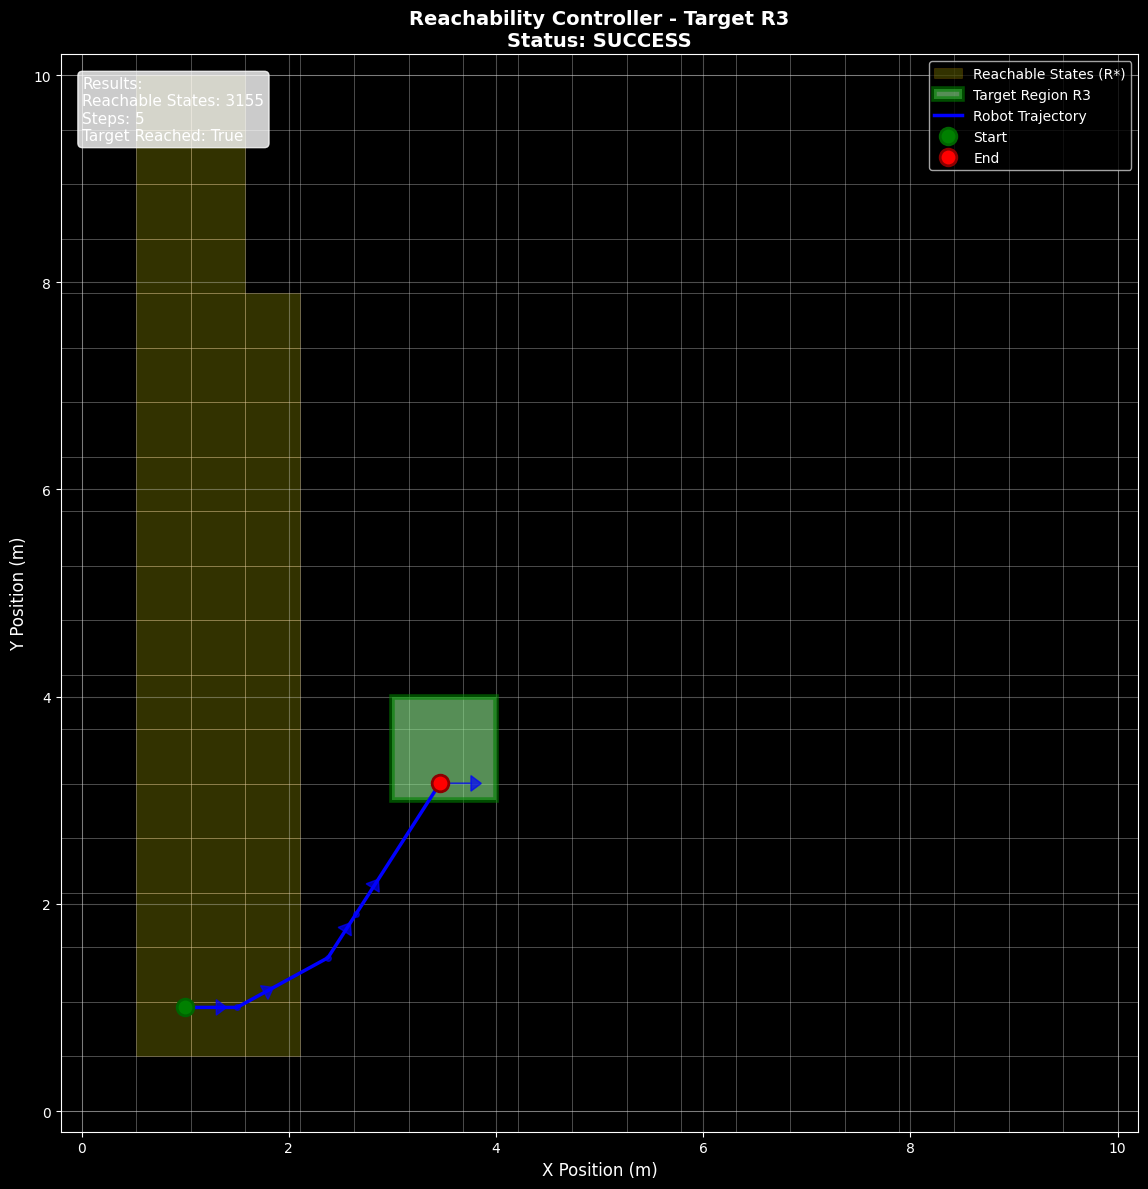


REACHABILITY ANALYSIS
Reachable states (R*): 3155
Trajectory steps: 5
Target reached: True
Final position: (3.46, 3.16)


Testing multiple scenarios...

REACHABILITY TEST 1: [2.5, 2.5, 3.141592653589793]
Computing R* (reachability fixed point)...
Iteration 1: |R| = 198
Iteration 2: |R| = 606
Iteration 3: |R| = 1212
Iteration 4: |R| = 1905
Iteration 5: |R| = 2443
Iteration 6: |R| = 2876
Iteration 7: |R| = 3123
Iteration 8: |R| = 3155
Iteration 9: |R| = 3155
R* computation completed: 3155 reachable states
Computing reachability controller...
Reachability controller computed for 3074 states

Starting reachability-controlled simulation...
Initial state: [2.5, 2.5, 3.141592653589793]
Target region: [[3.0, 4.0], [3.0, 4.0]]
Step 0: Position (2.00, 2.50), State 2589
Step 10: Position (5.67, 2.85), State 3084
🎯 TARGET REACHED at step 18!
Simulation completed: 20 steps
Target reached: True


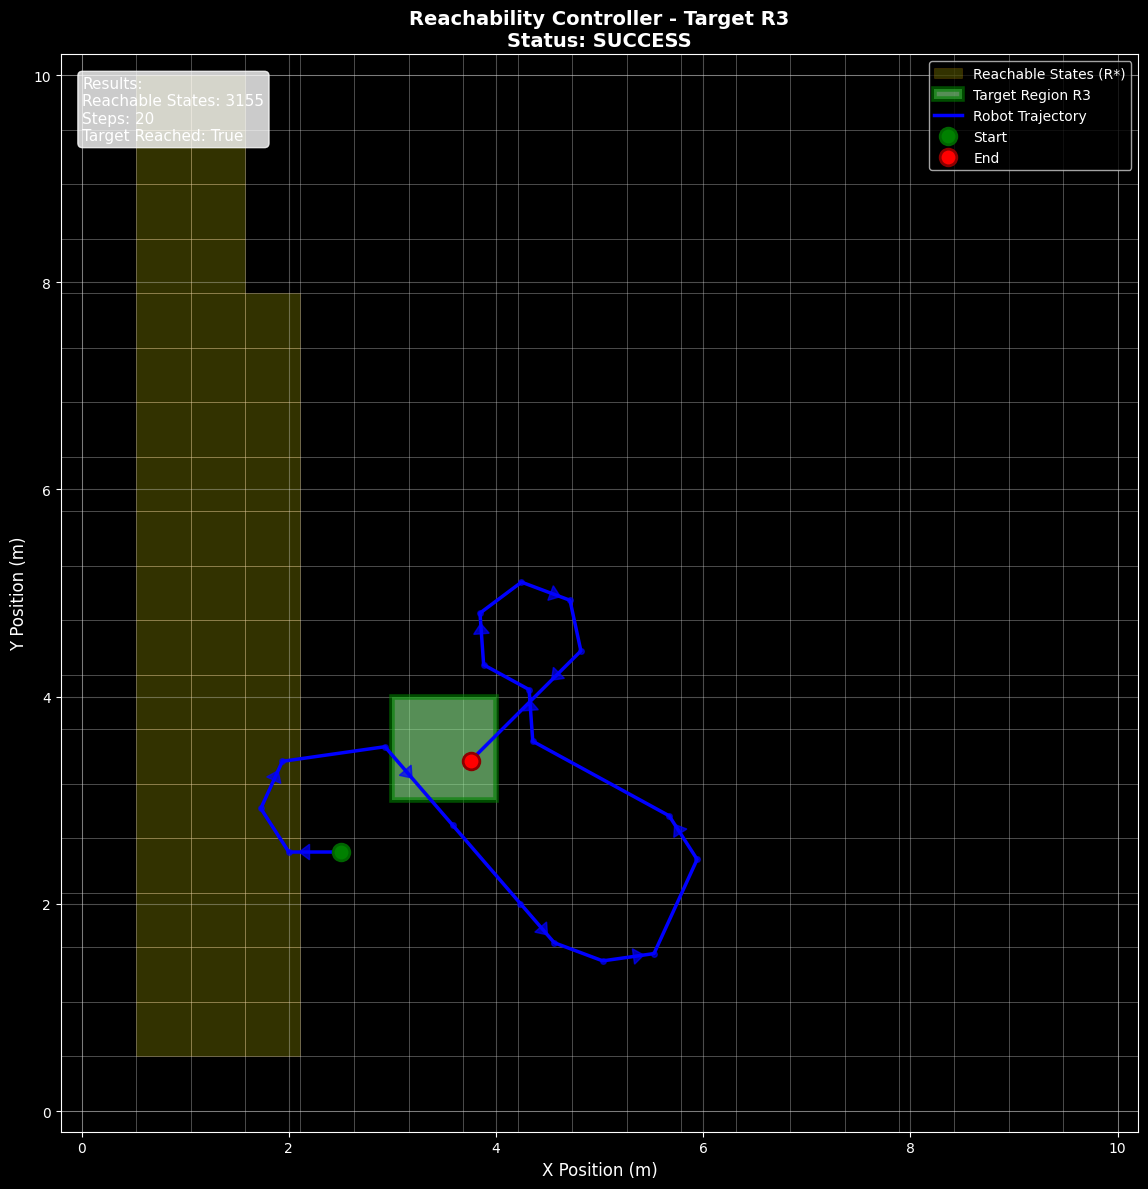


REACHABILITY ANALYSIS
Reachable states (R*): 3155
Trajectory steps: 20
Target reached: True
Final position: (3.76, 3.38)


REACHABILITY TESTS SUMMARY
Successful: 1/1
Reachable but not reached: 0/1
Not reachable: 0/1


In [22]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from collections import deque

class SymbolicReachabilityController:
    """
    Contrôleur d'atteignabilité symbolique basé sur l'algorithme 2 et théorème 4
    """
    
    def __init__(self, robot, target_states):
        self.robot = robot
        self.target_states = target_states  # Q_0 - états cibles
        self.R_star = None  # Point fixe R*
        self.R_sequence = []  # Séquence R_k pour le contrôle
        self.H = {}  # Contrôleur multivalué
        
    def compute_R_star(self):
        """
        Algorithme 2: Calcul du point fixe R* pour l'atteignabilité
        R_{k+1} = Q_0 ∪ Pre(R_k)
        """
        print("Computing R* (reachability fixed point)...")
        
        # R_0 = Q_0 (états cibles)
        R_prev = set(self.target_states)
        self.R_sequence = [R_prev.copy()]
        iteration = 0
        
        while True:
            iteration += 1
            
            # R_{k+1} = Q_0 ∪ Pre(R_k)
            R_new = set(self.target_states)  # Commencer avec Q_0
            R_new.update(self.pre(R_prev))   # Union avec Pre(R_k)
            
            print(f"Iteration {iteration}: |R| = {len(R_new)}")
            self.R_sequence.append(R_new.copy())
            
            # Condition de point fixe
            if R_new == R_prev:
                break
                
            R_prev = R_new
            
            # Sécurité: éviter les boucles infinies
            if iteration > 100:
                print("Warning: Maximum iterations reached")
                break
        
        self.R_star = R_new
        print(f"R* computation completed: {len(self.R_star)} reachable states")
        return self.R_star
    
    def pre(self, R):
        """
        Opérateur Pre(R) - états qui peuvent atteindre R en une étape
        """
        pre_states = set()
        
        # Pour chaque état possible, vérifier s'il peut atteindre R
        for state in range(1, len(self.robot.index_to_intervals) + 1):
            if self._can_reach_set(state, R):
                pre_states.add(state)
        
        return pre_states
    
    def _can_reach_set(self, state, target_set):
        """
        Vérifie si un état peut atteindre l'ensemble cible en une étape
        """
        possible_actions = self._get_possible_actions(state)
        
        for action in possible_actions:
            next_states = self._get_next_states(state, action)
            
            # Vérifier si au moins un successeur est dans l'ensemble cible
            for next_state in next_states:
                if next_state in target_set:
                    return True
        
        return False
    
    def _get_possible_actions(self, state):
        """
        Retourne les actions possibles depuis un état discret
        """
        actions = []
        for v in [0.5, 1.0, 1.5]:
            for omega in [-1.0, -0.5, 0, 0.5, 1.0]:
                actions.append((v, omega))
        return actions
    
    def _get_next_states(self, state, action):
        """
        Simule les états successeurs possibles
        """
        next_states = []
        
        if state not in self.robot.index_to_intervals:
            return next_states
            
        # Obtenir la position continue
        intervals = self.robot.index_to_intervals[state]
        x_center = (intervals[0][0] + intervals[0][1]) / 2
        y_center = (intervals[1][0] + intervals[1][1]) / 2
        theta_center = (intervals[2][0] + intervals[2][1]) / 2
        
        # Appliquer la dynamique
        v, omega = action
        w_center = np.zeros(3)
        D_x, D_w = self.robot.compute_Dx_and_Dw(action)
        
        x_next_lower, x_next_upper = self.robot.dynamics(
            np.array([x_center, y_center, theta_center]), 
            np.array([v, omega]), 
            w_center, D_x, D_w
        )
        
        # Échantillonner les successeurs
        sample_points = 3
        for i in range(sample_points):
            for j in range(sample_points):
                for k in range(sample_points):
                    alpha_x = i / (sample_points - 1) if sample_points > 1 else 0.5
                    alpha_y = j / (sample_points - 1) if sample_points > 1 else 0.5
                    alpha_theta = k / (sample_points - 1) if sample_points > 1 else 0.5
                    
                    x_sample = x_next_lower[0] + alpha_x * (x_next_upper[0] - x_next_lower[0])
                    y_sample = x_next_lower[1] + alpha_y * (x_next_upper[1] - x_next_lower[1])
                    theta_sample = x_next_lower[2] + alpha_theta * (x_next_upper[2] - x_next_lower[2])
                    
                    discrete_state = self.robot._find_state(np.array([x_sample, y_sample, theta_sample]))
                    if discrete_state != -1:
                        next_states.append(discrete_state)
        
        return list(set(next_states))
    
    def compute_reachability_controller(self):
        """
        Calcule le contrôleur d'atteignabilité selon le théorème 4
        ∀k ∈ N, ∀ξ ∈ R_{k+1}, ∅ ≠ g(ξ, h(ξ)) ⊆ R_k
        """
        if self.R_star is None:
            self.compute_R_star()
            
        print("Computing reachability controller...")
        
        # Pour chaque état dans R*, trouver les actions qui mènent vers la cible
        for state in self.R_star:
            # Trouver le plus petit k tel que state ∈ R_k
            k_level = None
            for k, R_k in enumerate(self.R_sequence):
                if state in R_k:
                    k_level = k
                    break
            
            if k_level is not None and k_level > 0:
                # Nous voulons atteindre R_{k-1}
                target_set = self.R_sequence[k_level - 1]
                valid_actions = []
                
                possible_actions = self._get_possible_actions(state)
                for action in possible_actions:
                    next_states = self._get_next_states(state, action)
                    
                    # Vérifier si au moins un successeur est dans target_set
                    reaches_target = any(ns in target_set for ns in next_states)
                    
                    if reaches_target and next_states:  # Condition du théorème 4
                        valid_actions.append(action)
                
                self.H[state] = valid_actions
        
        print(f"Reachability controller computed for {len(self.H)} states")
        return self.H
    
    def get_reachability_action(self, continuous_state):
        """
        Implémente le contrôleur concrétisé pour l'atteignabilité
        """
        # Discrétisation
        discrete_state = self.robot._find_state(np.array(continuous_state))
        
        # Vérifier si l'état est dans R*
        if discrete_state in self.H and self.H[discrete_state]:
            # Choisir une action valide
            return self.H[discrete_state][0]
        else:
            # Action par défaut (exploration)
            print(f"Warning: No reachability action for state {discrete_state}")
            return (1.0, 0.0)  # Avancer tout droit

def run_reachability_simulation(robot, reachability_controller, initial_state, target_bounds, steps=100):
    """
    Exécute une simulation avec le contrôleur d'atteignabilité
    """
    print(f"\nStarting reachability-controlled simulation...")
    print(f"Initial state: {initial_state}")
    print(f"Target region: {target_bounds}")
    
    trajectory = [initial_state]
    current_state = initial_state.copy()
    target_reached = False
    
    for step in range(steps):
        # Obtenir l'action du contrôleur d'atteignabilité
        action = reachability_controller.get_reachability_action(current_state)
        
        # Appliquer l'action
        w_center = np.zeros(3)
        D_x, D_w = robot.compute_Dx_and_Dw(action)
        
        x_next_lower, x_next_upper = robot.dynamics(
            np.array(current_state), 
            np.array(action), 
            w_center, D_x, D_w
        )
        
        # Prendre le point médian
        next_state = [
            (x_next_lower[0] + x_next_upper[0]) / 2,
            (x_next_lower[1] + x_next_upper[1]) / 2,
            (x_next_lower[2] + x_next_upper[2]) / 2
        ]
        
        trajectory.append(next_state)
        current_state = next_state
        
        # Vérifier si la cible est atteinte
        if is_in_target_region(current_state, target_bounds):
            print(f"🎯 TARGET REACHED at step {step}!")
            target_reached = True
            break
        
        # Rapport de progression
        if step % 10 == 0:
            discrete_state = robot._find_state(np.array(current_state))
            print(f"Step {step}: Position ({current_state[0]:.2f}, {current_state[1]:.2f}), State {discrete_state}")
    
    print(f"Simulation completed: {len(trajectory)} steps")
    print(f"Target reached: {target_reached}")
    return trajectory, target_reached

def is_in_target_region(state, target_bounds):
    """
    Vérifie si l'état est dans la région cible R3
    """
    x, y, theta = state
    
    # Gérer différents formats de target_bounds
    if isinstance(target_bounds, list):
        if len(target_bounds) == 2 and isinstance(target_bounds[0], (list, tuple)):
            # Format: [[x_min, x_max], [y_min, y_max]]
            x_min, x_max = target_bounds[0]
            y_min, y_max = target_bounds[1]
        elif len(target_bounds) == 4:
            # Format: [x_min, x_max, y_min, y_max]
            x_min, x_max, y_min, y_max = target_bounds
        else:
            return False
    else:
        return False
    
    return (x_min <= x <= x_max) and (y_min <= y <= y_max)

def visualize_reachability_results(robot, trajectory, R_star, target_bounds, reachability_controller, target_reached):
    """
    Visualisation des résultats d'atteignabilité
    """
    x = [state[0] for state in trajectory]
    y = [state[1] for state in trajectory]
    theta = [state[2] for state in trajectory]

    fig, ax = plt.subplots(figsize=(14, 12))

    # Grille
    x_edges = robot.state_edges[0]
    y_edges = robot.state_edges[1]

    for x_edge in x_edges:
        ax.axvline(x=x_edge, color='lightgray', linestyle='-', linewidth=0.5, alpha=0.5)
    for y_edge in y_edges:
        ax.axhline(y=y_edge, color='lightgray', linestyle='-', linewidth=0.5, alpha=0.5)

    # États atteignables R* (optionnel)
    reachable_count = 0
    max_to_show = 50
    
    for state in list(R_star)[:max_to_show]:
        if state in robot.index_to_intervals:
            intervals = robot.index_to_intervals[state]
            reach_rect = patches.Rectangle(
                (intervals[0][0], intervals[1][0]),
                intervals[0][1] - intervals[0][0],
                intervals[1][1] - intervals[1][0],
                linewidth=0.5,
                edgecolor='orange',
                facecolor='yellow',
                alpha=0.2,
                label='Reachable States (R*)' if reachable_count == 0 else "",
                zorder=1
            )
            ax.add_patch(reach_rect)
            reachable_count += 1

    # Région cible R3
    if isinstance(target_bounds, list):
        if len(target_bounds) == 2 and isinstance(target_bounds[0], (list, tuple)):
            x_min, x_max = target_bounds[0]
            y_min, y_max = target_bounds[1]
        elif len(target_bounds) == 4:
            x_min, x_max, y_min, y_max = target_bounds
    
    target_rect = patches.Rectangle(
        (x_min, y_min),
        x_max - x_min,
        y_max - y_min,
        linewidth=4,
        edgecolor='green',
        facecolor='lightgreen',
        alpha=0.6,
        label='Target Region R3',
        zorder=2
    )
    ax.add_patch(target_rect)

    # Trajectoire
    ax.plot(x, y, 'b-', linewidth=2.5, label='Robot Trajectory', zorder=3)
    ax.plot(x, y, 'bo', markersize=4, alpha=0.6, zorder=4)

    # Flèches d'orientation
    arrow_interval = max(1, len(x)//8)
    for i in range(0, len(x), arrow_interval):
        dx = 0.3 * np.cos(theta[i])
        dy = 0.3 * np.sin(theta[i])
        ax.arrow(x[i], y[i], dx, dy, head_width=0.15, head_length=0.1, 
                 fc='blue', ec='blue', alpha=0.7, zorder=5)

    # Début et fin
    ax.plot(x[0], y[0], 'go', markersize=12, label='Start', zorder=6, 
            markeredgecolor='darkgreen', markeredgewidth=2)
    ax.plot(x[-1], y[-1], 'ro', markersize=12, label='End', zorder=6,
            markeredgecolor='darkred', markeredgewidth=2)

    # Personnalisation
    status = "SUCCESS" if target_reached else "IN PROGRESS"
    ax.set_title(f'Reachability Controller - Target R3\nStatus: {status}', 
                 fontsize=14, fontweight='bold')
    ax.set_xlabel('X Position (m)', fontsize=12)
    ax.set_ylabel('Y Position (m)', fontsize=12)
    ax.legend(fontsize=10, loc='upper right')
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)

    # Limites
    ax.set_xlim(x_edges[0] - 0.2, x_edges[-1] + 0.2)
    ax.set_ylim(y_edges[0] - 0.2, y_edges[-1] + 0.2)

    # Information
    info_text = f"Results:\nReachable States: {len(R_star)}\nSteps: {len(trajectory)}\nTarget Reached: {target_reached}"
    ax.text(0.02, 0.98, info_text, transform=ax.transAxes, fontsize=11,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()

    # Analyse
    print(f"\n{'='*60}")
    print(f"REACHABILITY ANALYSIS")
    print(f"{'='*60}")
    print(f"Reachable states (R*): {len(R_star)}")
    print(f"Trajectory steps: {len(trajectory)}")
    print(f"Target reached: {target_reached}")
    print(f"Final position: ({x[-1]:.2f}, {y[-1]:.2f})")
    print(f"{'='*60}\n")

# Fonction principale pour l'atteignabilité
def main_reachability():
    """
    Test du contrôleur d'atteignabilité pour atteindre R3
    """
    # Définir la région cible R3 (exemple)
    R3_bounds = [[3.0, 4.0], [3.0, 4.0]]  # [x_min, x_max], [y_min, y_max]
    
    # Trouver les états discrets dans R3
    R3_states = robot.find_indices_for_interval([
        (R3_bounds[0][0], R3_bounds[0][1]),
        (R3_bounds[1][0], R3_bounds[1][1]),
        (robot.state_intervals[2][0], robot.state_intervals[2][1])  # Tout theta
    ])
    
    print(f"Target region R3: {R3_bounds}")
    print(f"Target states: {len(R3_states)}")
    
    # État initial
    initial_state = [1.0, 1.0, 0.0]
    
    # Contrôleur d'atteignabilité
    reach_controller = SymbolicReachabilityController(robot, R3_states)
    
    # Calculer R*
    R_star = reach_controller.compute_R_star()
    
    # Vérifier l'état initial
    initial_discrete = robot._find_state(np.array(initial_state))
    if initial_discrete in R_star:
        print(f"✓ Initial state {initial_discrete} can reach target")
    else:
        print(f"✗ Initial state {initial_discrete} cannot reach target")
        return
    
    # Calculer le contrôleur
    reach_controller.compute_reachability_controller()
    
    # Simulation
    trajectory, target_reached = run_reachability_simulation(
        robot, reach_controller, initial_state, R3_bounds, steps=50
    )
    
    # Visualisation
    visualize_reachability_results(
        robot, trajectory, R_star, R3_bounds, reach_controller, target_reached
    )

# Test avec différents états initiaux
def test_reachability_scenarios():
    """
    Test différents scénarios d'atteignabilité
    """
    # Région cible R3
    R3_bounds = [[3.0, 4.0], [3.0, 4.0]]
    
    R3_states = robot.find_indices_for_interval([
        (R3_bounds[0][0], R3_bounds[0][1]),
        (R3_bounds[1][0], R3_bounds[1][1]),
        (robot.state_intervals[2][0], robot.state_intervals[2][1])
    ])
    
    # Différents états initiaux à tester
    test_states = [
        
        #[2.0, 1.0, np.pi/2],  # Bas centre, orienté vers le haut
       # [1.0, 3.0, 0.0],      # Gauche centre
       [2.5, 2.5, np.pi],    # Centre, orienté vers la gauche
        #[4.0, 1.0, -np.pi/2], # Coin inférieur droit
    ]
    
    results = []
    
    for i, start_state in enumerate(test_states):
        print(f"\n{'='*50}")
        print(f"REACHABILITY TEST {i+1}: {start_state}")
        print(f"{'='*50}")
        
        reach_controller = SymbolicReachabilityController(robot, R3_states)
        R_star = reach_controller.compute_R_star()
        reach_controller.compute_reachability_controller()
        
        initial_discrete = robot._find_state(np.array(start_state))
        
        if initial_discrete in R_star:
            trajectory, reached = run_reachability_simulation(
                robot, reach_controller, start_state, R3_bounds, steps=40
            )
            
            results.append({
                'test': i+1,
                'start_state': start_state,
                'reachable': True,
                'target_reached': reached,
                'steps': len(trajectory)
            })
            
            # Visualiser seulement quelques tests
            if i < 2:
                visualize_reachability_results(
                    robot, trajectory, R_star, R3_bounds, reach_controller, reached
                )
        else:
            print(f"✗ Cannot reach target from {start_state}")
            results.append({
                'test': i+1,
                'start_state': start_state,
                'reachable': False,
                'target_reached': False,
                'steps': 0
            })
    
    # Résumé
    print(f"\n{'='*60}")
    print(f"REACHABILITY TESTS SUMMARY")
    successful = [r for r in results if r['target_reached']]
    reachable_but_not_reached = [r for r in results if r['reachable'] and not r['target_reached']]
    
    print(f"Successful: {len(successful)}/{len(results)}")
    print(f"Reachable but not reached: {len(reachable_but_not_reached)}/{len(results)}")
    print(f"Not reachable: {len(results) - len(successful) - len(reachable_but_not_reached)}/{len(results)}")

# Exécution
if __name__ == "__main__":
    print("Testing Symbolic Reachability Controller")
    main_reachability()
    
    # Tests supplémentaires
    print("\nTesting multiple scenarios...")
    test_reachability_scenarios()

Testing Safe Reachability Controller (FAST): Reach R3, Avoid R4
Target region R3 -> 20 states
Unsafe region R4 -> 20 states
Computing safe R* (fast BFS)...
Iteration 1: |R*| = 31
Iteration 2: |R*| = 68
Iteration 3: |R*| = 133
Iteration 4: |R*| = 211
Iteration 5: |R*| = 299
Iteration 6: |R*| = 359
Iteration 7: |R*| = 385
Iteration 8: |R*| = 389
Iteration 9: |R*| = 390
Iteration 10: |R*| = 390
Safe R* done. Total states: 390 (cap 40 iters).
✓ Initial state 163 can safely reach target
Computing safe controller policy...
Policy computed for 390 states.

Starting SAFE simulation...
Step 0: (2.00, 1.00), state 91, SAFE
Step 10: (4.65, 2.83), state 282, SAFE
🎯 TARGET REACHED at step 12!
Simulation done: steps=14 | target=True | violations=0


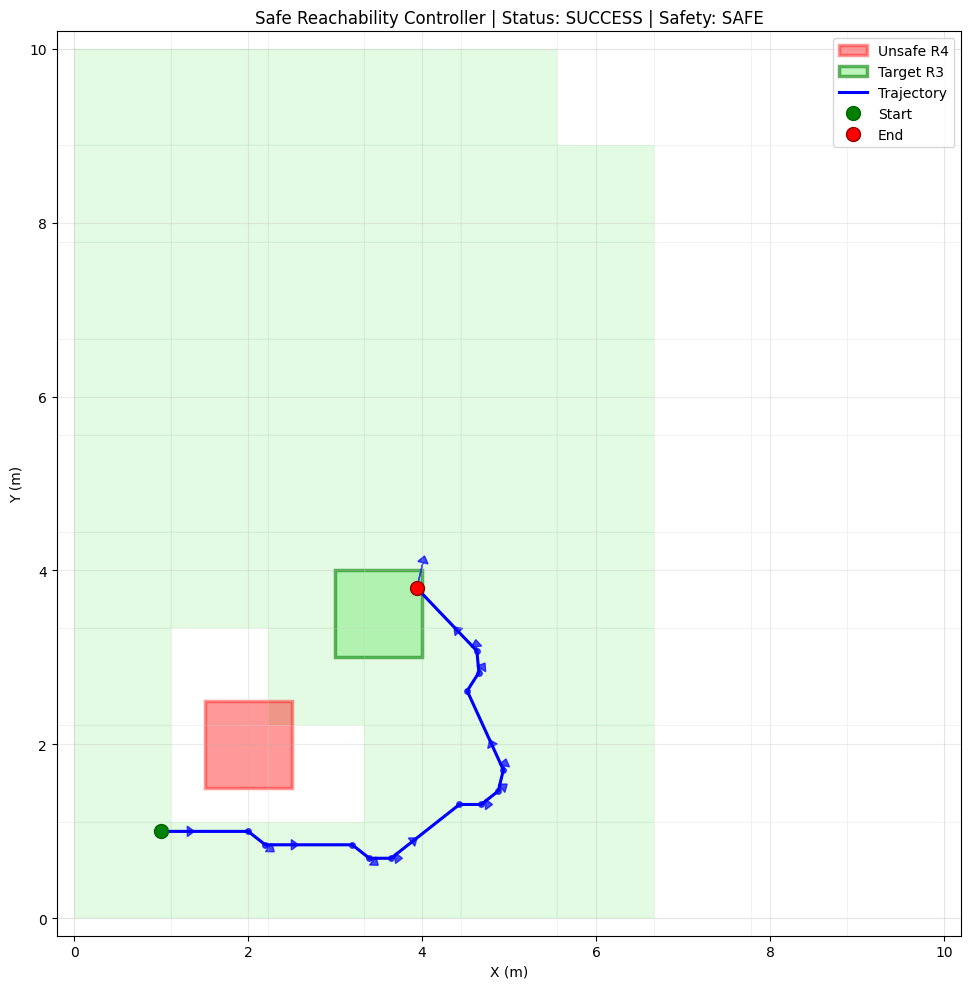


SAFE REACHABILITY ANALYSIS
Safe reachable states (R*): 390
Trajectory steps: 14
Target reached: True
Safety violations: 0
Final position: (3.94, 3.80)
🎯 PERFECT: Target reached with no safety violations!



In [ ]:



# safe_reachability_fast.py
import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib.patches as patches


class RobotAbstraction:
    def __init__(self, state_intervals, control_values, perturbation, delta_t):
        self.state_intervals = state_intervals
        self.control_values = control_values
        self.perturbation = perturbation
        self.delta_t = delta_t

        # Discretization (10x10x6 = 600 states)
        self.discrete_x_y = 10
        self.discrete_tetha = 6

        # Action sampling (denser for better reachability)
        self.v_vals = 4      # finer linear speed sampling
        self.omega_vals = 7  # finer angular speed sampling

        self.state_to_index = {"OutOfGrid": -1}
        self.index_to_intervals = {}
        self.state_edges = []

        self._create_state_mapping()

    def _create_state_mapping(self):
        self.state_edges = [
            np.linspace(interval[0], interval[1], self.discrete_x_y) for interval in self.state_intervals[:2]
        ]
        self.state_edges.append(
            np.linspace(self.state_intervals[2][0], self.state_intervals[2][1], self.discrete_tetha)
        )

        # fill mapping index -> intervals
        state_grid = np.array(np.meshgrid(*[edges[:-1] for edges in self.state_edges])).T.reshape(-1, 3)
        for idx, state in enumerate(state_grid, start=1):
            discrete_state = tuple(
                np.digitize(state[i], self.state_edges[i]) for i in range(len(state))
            )
            self.state_to_index[discrete_state] = idx
            intervals = []
            for i, edge in enumerate(self.state_edges):
                low = edge[discrete_state[i] - 1]
                high = edge[discrete_state[i]]
                intervals.append((low, high))
            self.index_to_intervals[idx] = intervals

    def compute_Dx_and_Dw(self, u):
        # small linearization buffers used only for over-approximation
        D_x = np.array([
            [1, 0, self.delta_t * 0.25],
            [0, 1, self.delta_t * 0.25],
            [0, 0, 1]
        ])
        D_w = np.array([
            [self.delta_t, 0, 0],
            [0, self.delta_t, 0],
            [0, 0, self.delta_t]
        ])
        return D_x, D_w

    def dynamics(self, x_center, u, w_center, D_x, D_w):
        # nominal dynamics (used in simulation for a more accurate step)
        nominal = np.array([
            x_center[0] + self.delta_t * (u[0] * np.cos(x_center[2]) + w_center[0]),
            x_center[1] + self.delta_t * (u[0] * np.sin(x_center[2]) + w_center[1]),
            x_center[2] + self.delta_t * (u[1] + w_center[2])
        ])

        # conservative buffers (only for reachability over-approximation)
        # reduced slightly to avoid excessive contraction that made the controller stall
        delta_x = np.array([3/99, 3/99, np.pi / 60])
        delta_w = np.array([0.015, 0.015, 0.015])

        low = nominal - D_x @ delta_x - D_w @ delta_w
        up  = nominal + D_x @ delta_x + D_w @ delta_w
        return low, up, nominal

    def _find_state(self, x):
        # wrap theta to [-pi, pi] when mapping
        x = np.array(x, dtype=float)
        x[2] = ((x[2] + np.pi) % (2 * np.pi)) - np.pi
        discrete_state = tuple(
            min(np.digitize(x[i], self.state_edges[i]), len(self.state_edges[i]) - 1)
            for i in range(len(x))
        )
        return self.state_to_index.get(discrete_state, -1)

    def find_indices_for_interval(self, interval):
        overlapping_indices = []
        for index, intervals in self.index_to_intervals.items():
            overlap = True
            for dim in range(len(interval)):
                if not (interval[dim][1] >= intervals[dim][0] and interval[dim][0] <= intervals[dim][1]):
                    overlap = False
                    break
            if overlap:
                overlapping_indices.append(index)
        return overlapping_indices

    def sample_actions(self):
        v_vals = np.linspace(self.control_values[0][0], self.control_values[0][1], self.v_vals)
        omega_vals = np.linspace(self.control_values[1][0], self.control_values[1][1], self.omega_vals)
        return [(float(v), float(om)) for v, om in itertools.product(v_vals, omega_vals)]

    def successors_overapprox(self, state, action, samples=3):
        """Return discrete successor states over-approximated and sampled."""
        if state not in self.index_to_intervals:
            return []
        intervals = self.index_to_intervals[state]
        x_center = (intervals[0][0] + intervals[0][1]) / 2
        y_center = (intervals[1][0] + intervals[1][1]) / 2
        theta_center = (intervals[2][0] + intervals[2][1]) / 2

        w_center = np.zeros(3)
        D_x, D_w = self.compute_Dx_and_Dw(action)
        low, up, _ = self.dynamics(np.array([x_center, y_center, theta_center]),
                                   np.array(action), w_center, D_x, D_w)

        succ = set()
        for i in range(samples):
            for j in range(samples):
                for k in range(samples):
                    ax = i / (samples - 1) if samples > 1 else 0.5
                    ay = j / (samples - 1) if samples > 1 else 0.5
                    at = k / (samples - 1) if samples > 1 else 0.5
                    xs = low[0] + ax * (up[0] - low[0])
                    ys = low[1] + ay * (up[1] - low[1])
                    th = low[2] + at * (up[2] - low[2])
                    sidx = self._find_state(np.array([xs, ys, th]))
                    if sidx != -1:
                        succ.add(sidx)
        return list(succ)



class SafeReachabilityController:
    """
    Reach R3 while avoiding R4. Fast version:
    - Precompute successors for all state-action pairs once
    - Backward BFS from target to compute R* and levels
    - Controller picks actions that decrease level and avoid R4
    """
    def __init__(self, robot, target_states, unsafe_states):
        self.robot = robot
        self.target_states = set(target_states)
        self.unsafe_states = set(unsafe_states)
        self.R_star = set()
        self.level = {}   # state -> BFS level (0 for target states)
        self.H = {}       # multivalued safe controller: state -> list of actions

        # Precompute transitions for all states and actions (huge speed-up)
        self.actions = self.robot.sample_actions()
        self.transitions = {}  # (state, action) -> [next_states]
        for state in self.robot.index_to_intervals.keys():
            for a in self.actions:
                # increase samples slightly for better coverage
                self.transitions[(state, a)] = self.robot.successors_overapprox(state, a, samples=3)

    def compute_R_star(self):
        """
        Backward BFS:
        - Start frontier with target_states (level 0)
        - Add states that can reach frontier with a safe action:
          any successor in frontier AND all successors not in R4.
        """
        print("Computing safe R* (fast BFS)...")
        frontier = set(self.target_states)
        self.R_star = set(frontier)
        for s in frontier:
            self.level[s] = 0

        max_iters = 40  # slightly higher cap
        it = 0

        while frontier and it < max_iters:
            it += 1
            new_frontier = set()
            # scan all states; add those that can reach current frontier safely
            for state in self.robot.index_to_intervals.keys():
                if state in self.R_star:  # already in
                    continue
                if state in self.unsafe_states:
                    continue
                # exists a safe action that reaches frontier
                for a in self.actions:
                    succ = self.transitions[(state, a)]
                    if not succ:
                        continue
                    reaches_frontier = any(ns in frontier for ns in succ)
                    avoids_unsafe = all(ns not in self.unsafe_states for ns in succ)
                    if reaches_frontier and avoids_unsafe:
                        self.R_star.add(state)
                        self.level[state] = self._min_level_in(succ, default=it) + 1
                        new_frontier.add(state)
                        break
            frontier = new_frontier
            print(f"Iteration {it}: |R*| = {len(self.R_star)}")

        print(f"Safe R* done. Total states: {len(self.R_star)} (cap {max_iters} iters).")
        return self.R_star

    def _min_level_in(self, states, default=9999):
        vals = [self.level[s] for s in states if s in self.level]
        return min(vals) if vals else default

    def compute_safe_reachability_controller(self):
        """
        For each state in R*, pick actions whose successors:
        - stay out of R4
        - reduce level toward target (prefer lower level)
        Additionally, when multiple actions share the same best level reduction,
        prefer the action that improves geometric progress to the target center.
        """
        if not self.R_star:
            self.compute_R_star()
        print("Computing safe controller policy...")

        # precompute target centers (use mean of R3 intervals in x,y)
        target_center_xy = None

        # If R3 exists, approximate its center using the first state's intervals
        if len(self.target_states) > 0:
            any_target = next(iter(self.target_states))
            xi, yi, _ = self.robot.index_to_intervals[any_target]
            target_center_xy = np.array([(xi[0] + xi[1]) / 2.0, (yi[0] + yi[1]) / 2.0], dtype=float)

        for state in self.R_star:
            valid = []
            best_level = float('inf')
            best_progress = -float('inf')

            # extract a representative continuous state center for evaluating progress
            xi, yi, ti = self.robot.index_to_intervals[state]
            x_center = (xi[0] + xi[1]) / 2.0
            y_center = (yi[0] + yi[1]) / 2.0
            theta_center = (ti[0] + ti[1]) / 2.0
            xyt_center = np.array([x_center, y_center, theta_center], dtype=float)

            for a in self.actions:
                succ = self.transitions[(state, a)]
                if not succ:
                    continue
                avoids_unsafe = all(ns not in self.unsafe_states for ns in succ)
                succ_levels = [self.level.get(ns, float('inf')) for ns in succ]
                min_succ_level = min(succ_levels) if succ_levels else float('inf')

                # evaluate geometric progress (projected step toward target center)
                progress = -float('inf')
                if target_center_xy is not None:
                    # one-step nominal displacement length toward target center
                    # compute nominal next and its improvement in distance
                    w_center = np.zeros(3)
                    D_x, D_w = self.robot.compute_Dx_and_Dw(a)
                    _, _, nominal_next = self.robot.dynamics(xyt_center, np.array(a), w_center, D_x, D_w)
                    curr_dist = np.linalg.norm(target_center_xy - np.array([x_center, y_center]))
                    next_dist = np.linalg.norm(target_center_xy - nominal_next[:2])
                    progress = curr_dist - next_dist  # positive if moving closer

                # choose actions that move closer (lower level) and avoid R4
                if avoids_unsafe and min_succ_level < self.level.get(state, float('inf')):
                    if (min_succ_level < best_level) or (min_succ_level == best_level and progress > best_progress):
                        valid = [a]
                        best_level = min_succ_level
                        best_progress = progress
                    elif min_succ_level == best_level and np.isclose(progress, best_progress, atol=1e-6):
                        valid.append(a)

            self.H[state] = valid
        print(f"Policy computed for {len(self.H)} states.")
        return self.H

    def get_safe_reachability_action(self, continuous_state):
        """
        Pick the first valid action at this discrete state; emergency stop otherwise.
        """
        discrete_state = self.robot._find_state(np.array(continuous_state))
        actions = self.H.get(discrete_state, [])
        if actions:
            return actions[0]
        print(f"⚠️ Warning: No safe action for state {discrete_state}. Emergency stop.")
        return (0.0, 0.0)




def is_in_target_region(state, target_bounds):
    x, y, _ = state
    x_min, x_max = target_bounds[0]
    y_min, y_max = target_bounds[1]
    return (x_min <= x <= x_max) and (y_min <= y <= y_max)

def is_in_unsafe_region(state, unsafe_bounds):
    x, y, _ = state
    x_min, x_max = unsafe_bounds[0]
    y_min, y_max = unsafe_bounds[1]
    return (x_min <= x <= x_max) and (y_min <= y <= y_max)

def wrap_angle(theta):
    return ((theta + np.pi) % (2 * np.pi)) - np.pi

def run_safe_reachability_simulation(robot, safe_controller, initial_state, target_bounds, unsafe_bounds, steps=60):
    print("\nStarting SAFE simulation...")
    trajectory = [initial_state]
    current_state = initial_state.copy()
    target_reached = False
    safety_violations = 0

    # use nominal dynamics for the actual simulation step (not the interval midpoint)
    for step in range(steps):
        action = safe_controller.get_safe_reachability_action(current_state)
        w_center = np.zeros(3)
        D_x, D_w = robot.compute_Dx_and_Dw(action)
        _, _, nominal_next = robot.dynamics(np.array(current_state), np.array(action), w_center, D_x, D_w)
        next_state = [float(nominal_next[0]), float(nominal_next[1]), float(wrap_angle(nominal_next[2]))]

        trajectory.append(next_state)
        current_state = next_state

        if is_in_target_region(current_state, target_bounds):
            print(f"🎯 TARGET REACHED at step {step}!")
            target_reached = True
            break
        if is_in_unsafe_region(current_state, unsafe_bounds):
            safety_violations += 1
            print(f"🚨 SAFETY VIOLATION at step {step}! In R4")

        if step % 10 == 0:
            ds = robot._find_state(np.array(current_state))
            status = "SAFE" if ds in safe_controller.R_star else "UNSAFE"
            print(f"Step {step}: ({current_state[0]:.2f}, {current_state[1]:.2f}), state {ds}, {status}")

    print(f"Simulation done: steps={len(trajectory)} | target={target_reached} | violations={safety_violations}")
    return trajectory, target_reached, safety_violations

def visualize_safe_reachability_results(robot, trajectory, R_star, target_bounds, unsafe_bounds, target_reached, safety_violations):
    x = [s[0] for s in trajectory]
    y = [s[1] for s in trajectory]
    theta = [s[2] for s in trajectory]

    fig, ax = plt.subplots(figsize=(12, 10))

    # grid
    x_edges = robot.state_edges[0]
    y_edges = robot.state_edges[1]
    for xe in x_edges:
        ax.axvline(x=xe, color='lightgray', linewidth=0.4, alpha=0.5)
    for ye in y_edges:
        ax.axhline(y=ye, color='lightgray', linewidth=0.4, alpha=0.5)

    # visualize some safe cells
    for state in list(R_star)[:50]:
        if state in robot.index_to_intervals:
            xi, yi, _ = robot.index_to_intervals[state]
            rect = patches.Rectangle(
                (xi[0], yi[0]),
                xi[1] - xi[0],
                yi[1] - yi[0],
                linewidth=0.3,
                edgecolor='lightgreen',
                facecolor='lightgreen',
                alpha=0.25
            )
            ax.add_patch(rect)

    # unsafe region R4
    R4_x_min, R4_x_max = unsafe_bounds[0]
    R4_y_min, R4_y_max = unsafe_bounds[1]
    unsafe_rect = patches.Rectangle(
        (R4_x_min, R4_y_min), R4_x_max - R4_x_min, R4_y_max - R4_y_min,
        linewidth=2.5, edgecolor='red', facecolor='red', alpha=0.4, label='Unsafe R4'
    )
    ax.add_patch(unsafe_rect)

    # target region R3
    R3_x_min, R3_x_max = target_bounds[0]
    R3_y_min, R3_y_max = target_bounds[1]
    target_rect = patches.Rectangle(
        (R3_x_min, R3_y_min), R3_x_max - R3_x_min, R3_y_max - R3_y_min,
        linewidth=2.5, edgecolor='green', facecolor='lightgreen', alpha=0.6, label='Target R3'
    )
    ax.add_patch(target_rect)

    # trajectory
    color = 'blue' if safety_violations == 0 else 'orange'
    ax.plot(x, y, color=color, linewidth=2.2, label='Trajectory')
    ax.plot(x, y, color=color, marker='o', markersize=4, alpha=0.7)

    # orientation arrows
    step_arrow = max(1, len(x) // 8)
    for i in range(0, len(x), step_arrow):
        dx = 0.3 * np.cos(theta[i])
        dy = 0.3 * np.sin(theta[i])
        ax.arrow(x[i], y[i], dx, dy, head_width=0.12, head_length=0.08, fc=color, ec=color, alpha=0.7)

    # start/end
    ax.plot(x[0], y[0], 'go', markersize=10, label='Start', markeredgecolor='darkgreen')
    ax.plot(x[-1], y[-1], 'ro', markersize=10, label='End', markeredgecolor='darkred')

    status = "SUCCESS" if target_reached else "IN PROGRESS"
    safety_status = "SAFE" if safety_violations == 0 else f"UNSAFE ({safety_violations} violations)"
    ax.set_title(f"Safe Reachability Controller | Status: {status} | Safety: {safety_status}")
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")
    ax.legend(loc='upper right')
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.25)
    ax.set_xlim(x_edges[0] - 0.2, x_edges[-1] + 0.2)
    ax.set_ylim(y_edges[0] - 0.2, y_edges[-1] + 0.2)

    plt.tight_layout()
    plt.show()

    print("\n" + "="*60)
    print("SAFE REACHABILITY ANALYSIS")
    print("="*60)
    print(f"Safe reachable states (R*): {len(R_star)}")
    print(f"Trajectory steps: {len(trajectory)}")
    print(f"Target reached: {target_reached}")
    print(f"Safety violations: {safety_violations}")
    print(f"Final position: ({x[-1]:.2f}, {y[-1]:.2f})")
    if target_reached and safety_violations == 0:
        print("🎯 PERFECT: Target reached with no safety violations!")
    elif target_reached:
        print("⚠️ SUCCESS with safety violations")
    elif safety_violations == 0:
        print("🛡️ SAFE but target not reached")
    else:
        print("❌ FAILED: Neither safe nor target reached")
    print("="*60 + "\n")


# ==============================================================================
# MAIN
# ==============================================================================

def main_safe_reachability():
    # Regions
    R3_bounds = [[3.0, 4.0], [3.0, 4.0]]  # target
    R4_bounds = [[1.5, 2.5], [1.5, 2.5]]  # avoid

    # Robot abstraction
    state_intervals = [(0, 10), (0, 10), (-np.pi, np.pi)]
    perturbation = [(-0.05, 0.05), (-0.05, 0.05), (-np.pi, np.pi)]
    control_values = [(0.25, 1.0), (-1.0, 1.0)]
    delta_t = 1.0

    robot = RobotAbstraction(state_intervals, control_values, perturbation, delta_t)

    # Discrete sets
    R3_states = robot.find_indices_for_interval([
        (R3_bounds[0][0], R3_bounds[0][1]),
        (R3_bounds[1][0], R3_bounds[1][1]),
        (robot.state_intervals[2][0], robot.state_intervals[2][1])
    ])
    R4_states = robot.find_indices_for_interval([
        (R4_bounds[0][0], R4_bounds[0][1]),
        (R4_bounds[1][0], R4_bounds[1][1]),
        (robot.state_intervals[2][0], robot.state_intervals[2][1])
    ])
    print(f"Target region R3 -> {len(R3_states)} states")
    print(f"Unsafe region R4 -> {len(R4_states)} states")

    # Initial state
    initial_state = [1.0, 1.0, 0.0]

    # Controller
    safe_ctrl = SafeReachabilityController(robot, R3_states, R4_states)
    R_star = safe_ctrl.compute_R_star()

    init_disc = robot._find_state(np.array(initial_state))
    if init_disc in R_star:
        print(f" Initial state {init_disc} can safely reach target")
    else:
        print(f" Initial state {init_disc} cannot safely reach target")
        return

    safe_ctrl.compute_safe_reachability_controller()

    # Simulation
    trajectory, target_reached, safety_violations = run_safe_reachability_simulation(
        robot, safe_ctrl, initial_state, R3_bounds, R4_bounds, steps=60
    )

    # Visualization
    visualize_safe_reachability_results(
        robot, trajectory, R_star, R3_bounds, R4_bounds, target_reached, safety_violations
    )


if __name__ == "__main__":
    print("Testing Safe Reachability Controller (FAST): Reach R3, Avoid R4")
    main_safe_reachability()


DFA × NFA Controller: Visit (R1 XOR R2), Avoid R4, Reach R3
R1 states: 1 | R2 states: 1 | R3 states: 1 | R4 states: 4

=== DFA Structure ===
Initial: q0, Accepting: {'q3', 'q4'}
  q0 --[R1]--> q1
  q0 --[R2]--> q2
  q0 --[R3]--> q0
  q0 --[R4]--> qfail
  q0 --[other]--> q0
  q1 --[R1]--> q1
  q1 --[R2]--> qfail
  q1 --[R3]--> q3
  q1 --[R4]--> qfail
  q1 --[other]--> q1
  q2 --[R1]--> qfail
  q2 --[R2]--> q2
  q2 --[R3]--> q4
  q2 --[R4]--> qfail
  q2 --[other]--> q2

=== Building Augmented System (Grid × DFA) ===
Augmented states: 600 | Targets: 200

=== Computing R* via backward reachability ===
R* size: 500

=== Synthesizing controller on R* ===
Controller states: 300

=== Running closed-loop simulation ===
Step 0: cell=2, pos≈(1.50,0.50), DFA=q0, action=E
Step 10: cell=48, pos≈(7.50,4.50), DFA=q1, action=N
🎯 SPECIFICATION SATISFIED at step 14!


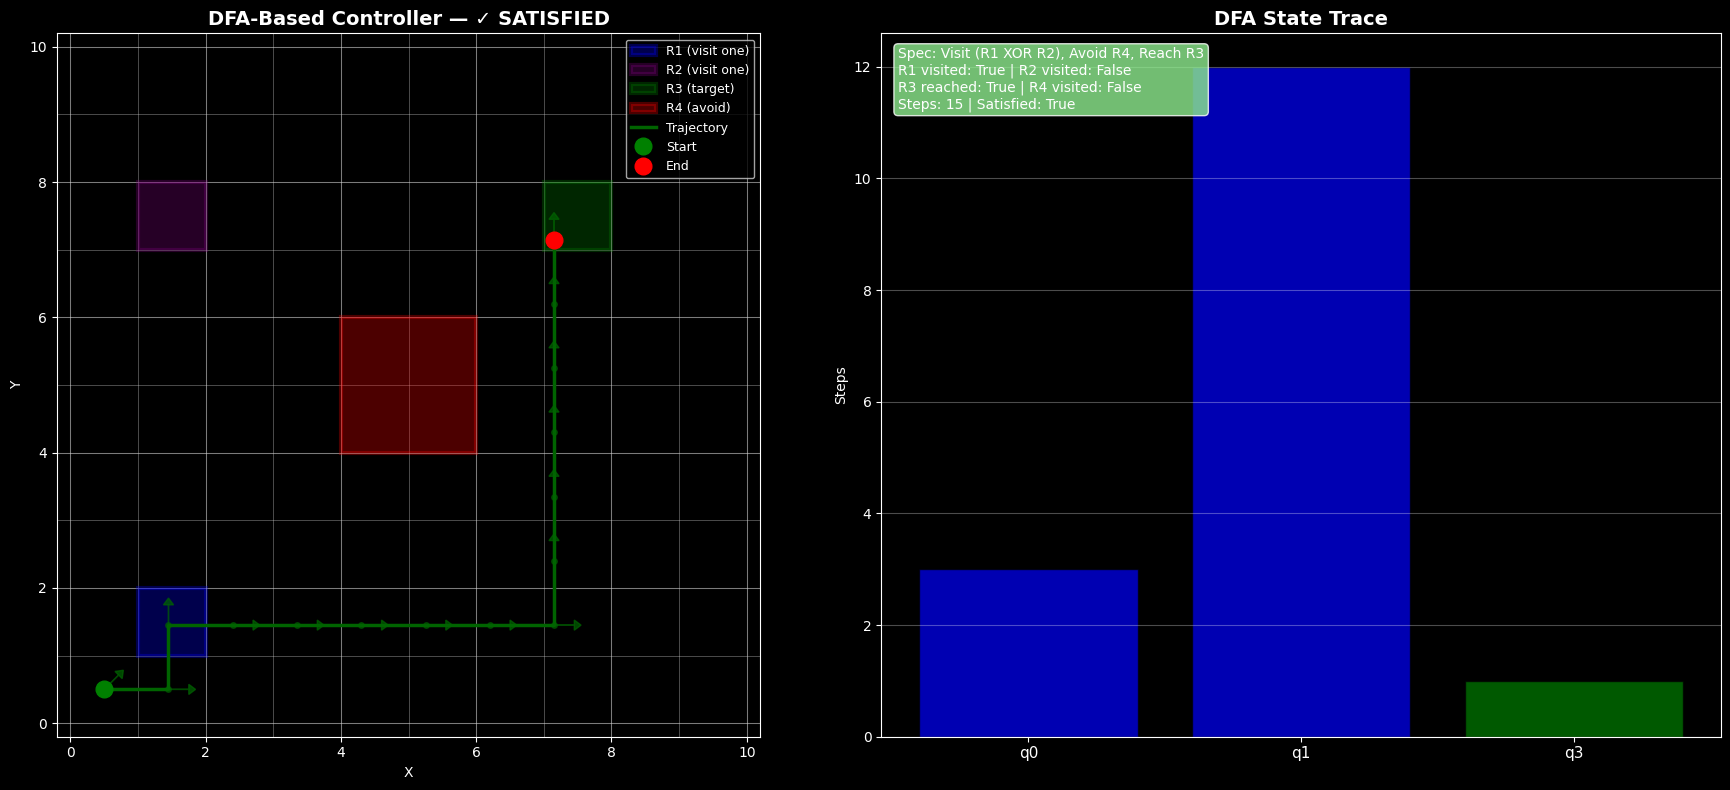

In [25]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from collections import deque

# ==========================
# Grid robot abstraction (NFA)
# ==========================

class MockRobot:
    def __init__(self):
        # 10x10 grid, each cell 1x1 over [0,10]x[0,10]
        x_edges = np.linspace(0, 10, 11)
        y_edges = np.linspace(0, 10, 11)
        theta_edges = np.array([0, 2 * np.pi])
        self.state_edges = [x_edges, y_edges, theta_edges]

        self.index_to_intervals = {}
        self.index_to_ij = {}
        self.ij_to_index = {}
        idx = 1
        for j in range(10):         # row (y)
            for i in range(10):     # col (x)
                self.index_to_intervals[idx] = (
                    (x_edges[i], x_edges[i+1]),
                    (y_edges[j], y_edges[j+1]),
                    (0, 2 * np.pi)
                )
                self.index_to_ij[idx] = (i, j)
                self.ij_to_index[(i, j)] = idx
                idx += 1

    def _find_state(self, x):
        x_pos, y_pos, theta = x
        x_pos = min(max(x_pos, 0.0), 9.999)
        y_pos = min(max(y_pos, 0.0), 9.999)
        i = int(np.floor(x_pos))
        j = int(np.floor(y_pos))
        return self.ij_to_index.get((i, j), -1)

    def find_indices_for_interval(self, bounds):
        x_min, x_max = bounds[0]
        y_min, y_max = bounds[1]
        indices = []
        for idx, ((x0, x1), (y0, y1), _) in self.index_to_intervals.items():
            if x0 < x_max and x1 > x_min and y0 < y_max and y1 > y_min:
                indices.append(idx)
        return indices

    ACTIONS = ['E', 'W', 'N', 'S']
    DELTAS = {
        'E': (1, 0),
        'W': (-1, 0),
        'N': (0, 1),
        'S': (0, -1),
    }

    def get_successors(self, xi, action):
        """Deterministic neighbor for a grid action."""
        if xi == -1 or action not in self.ACTIONS:
            return []
        i, j = self.index_to_ij[xi]
        di, dj = self.DELTAS[action]
        ni, nj = i + di, j + dj
        if 0 <= ni < 10 and 0 <= nj < 10:
            return [self.ij_to_index[(ni, nj)]]
        return [xi]  # if outside, clamp to stay

    def cell_center(self, xi):
        (x0, x1), (y0, y1), _ = self.index_to_intervals[xi]
        return (0.5 * (x0 + x1), 0.5 * (y0 + y1))

    def continuous_step(self, x, action):
        """Small continuous move for visualization aligned to action."""
        x_, y_, theta = x
        dt = 0.95
        speed = 1.0
        dx, dy = 0.0, 0.0
        if action == 'E':
            dx, dy = speed * dt, 0.0
            theta = 0.0
        elif action == 'W':
            dx, dy = -speed * dt, 0.0
            theta = np.pi
        elif action == 'N':
            dx, dy = 0.0, speed * dt
            theta = np.pi / 2
        elif action == 'S':
            dx, dy = 0.0, -speed * dt
            theta = -np.pi / 2
        return [x_ + dx, y_ + dy, theta]


# ==========================
# DFA for Visit (R1 XOR R2), Avoid R4, Reach R3
# ==========================

class DFA:
    def __init__(self):
        self.states = ['q0', 'q1', 'q2', 'q3', 'q4', 'qfail']
        self.initial_state = 'q0'
        self.accepting_states = {'q3', 'q4'}
        self.transitions = self._build_transitions()

    def _build_transitions(self):
        t = {}
        # q0: choose branch by visiting exactly one of R1/R2; avoid R4
        t[('q0', 'R1')] = 'q1'
        t[('q0', 'R2')] = 'q2'
        t[('q0', 'R3')] = 'q0'
        t[('q0', 'R4')] = 'qfail'
        t[('q0', 'other')] = 'q0'
        # q1: visited R1; visiting R2 -> fail; reaching R3 -> accept (q3)
        t[('q1', 'R1')] = 'q1'
        t[('q1', 'R2')] = 'qfail'
        t[('q1', 'R3')] = 'q3'
        t[('q1', 'R4')] = 'qfail'
        t[('q1', 'other')] = 'q1'
        # q2: visited R2; visiting R1 -> fail; reaching R3 -> accept (q4)
        t[('q2', 'R1')] = 'qfail'
        t[('q2', 'R2')] = 'q2'
        t[('q2', 'R3')] = 'q4'
        t[('q2', 'R4')] = 'qfail'
        t[('q2', 'other')] = 'q2'
        # absorbing
        for sym in ['R1', 'R2', 'R3', 'R4', 'other']:
            t[('q3', sym)] = 'q3'
            t[('q4', sym)] = 'q4'
            t[('qfail', sym)] = 'qfail'
        return t

    def step(self, q, symbol):
        return self.transitions.get((q, symbol), 'qfail')

    def visualize(self):
        print("\n=== DFA Structure ===")
        print(f"Initial: {self.initial_state}, Accepting: {self.accepting_states}")
        for (q, sym), qn in sorted(self.transitions.items()):
            if q in ['q0', 'q1', 'q2']:
                print(f"  {q} --[{sym}]--> {qn}")


# ==========================
# Augmented system (NFA × DFA)
# ==========================

class AugmentedSystem:
    def __init__(self, robot, dfa, R1_states, R2_states, R3_states, R4_states):
        self.robot = robot
        self.dfa = dfa
        self.R1 = set(R1_states)
        self.R2 = set(R2_states)
        self.R3 = set(R3_states)
        self.R4 = set(R4_states)

        self.augmented_states = []
        self.state_to_aug = {}
        self.aug_to_state = {}
        self.targets = set()
        self._build()

    def _build(self):
        print("\n=== Building Augmented System (Grid × DFA) ===")
        idx = 0
        for xi in range(1, 100 + 1):
            for q in self.dfa.states:
                s = (xi, q)
                self.augmented_states.append(s)
                self.state_to_aug[s] = idx
                self.aug_to_state[idx] = s
                if q in self.dfa.accepting_states:
                    self.targets.add(idx)
                idx += 1
        print(f"Augmented states: {len(self.augmented_states)} | Targets: {len(self.targets)}")

    def label(self, xi):
        if xi in self.R1: return 'R1'
        if xi in self.R2: return 'R2'
        if xi in self.R3: return 'R3'
        if xi in self.R4: return 'R4'
        return 'other'

    def successors(self, aug_idx, action):
        xi, q = self.aug_to_state[aug_idx]
        out = []
        for xn in self.robot.get_successors(xi, action):
            sym = self.label(xn)
            qn = self.dfa.step(q, sym)
            if qn == 'qfail':
                continue
            out.append(self.state_to_aug[(xn, qn)])
        return out


# ==========================
# Backward reachability and controller synthesis
# ==========================

class DFAReachabilityController:
    def __init__(self, aug):
        self.aug = aug
        self.R_star = None
        self.layers = []  # R^0, R^1, ...
        self.H = {}       # augmented index -> list of actions

    def actions(self):
        return ['E', 'W', 'N', 'S']

    def pre(self, R):
        A = self.actions()
        preS = set()
        for s in range(len(self.aug.augmented_states)):
            for a in A:
                succs = self.aug.successors(s, a)
                if any(t in R for t in succs):
                    preS.add(s)
                    break
        return preS

    def compute_R_star(self):
        print("\n=== Computing R* via backward reachability ===")
        R_prev = set(self.aug.targets)
        self.layers = [R_prev.copy()]  # layer 0: targets
        it = 0
        while True:
            it += 1
            R_new = set(self.aug.targets)
            R_new.update(self.pre(R_prev))
            self.layers.append(R_new.copy())
            if R_new == R_prev:
                break
            R_prev = R_new
            if it > 500:
                print("Warning: Max iterations reached.")
                break
        self.R_star = R_prev
        print(f"R* size: {len(self.R_star)}")
        return self.R_star

    def compute_controller(self):
        if self.R_star is None:
            self.compute_R_star()
        print("\n=== Synthesizing controller on R* ===")
        A = self.actions()
        for s in self.R_star:
            # find earliest layer containing s
            k = None
            for i, Ri in enumerate(self.layers):
                if s in Ri:
                    k = i
                    break
            if k is None or k == 0:
                continue
            target_layer = self.layers[k - 1]
            valid = []
            for a in A:
                succs = self.aug.successors(s, a)
                if succs and any(t in target_layer for t in succs):
                    valid.append(a)
            if valid:
                self.H[s] = valid
        print(f"Controller states: {len(self.H)}")
        return self.H


# ==========================
# Simulation using only the synthesized controller
# ==========================

def run_simulation(robot, aug, ctrl, initial_state, steps=250):
    print("\n=== Running closed-loop simulation ===")
    traj = [initial_state]
    xi = robot._find_state(np.array(initial_state))
    q = aug.dfa.initial_state
    aug_idx = aug.state_to_aug[(xi, q)]

    dfa_trace = [q]
    spec_ok = False
    visited = {'R1': False, 'R2': False, 'R3': False, 'R4': False}

    def region_flags(xi_local):
        lab = aug.label(xi_local)
        if lab in visited:
            visited[lab] = True
        return lab

    for step in range(steps):
        # Update DFA with current region
        lab = region_flags(xi)
        q = aug.dfa.step(q, lab)
        dfa_trace.append(q)
        if q == 'qfail':
            print(f"❌ SPECIFICATION FAILED at step {step}")
            break
        if q in aug.dfa.accepting_states:
            spec_ok = True
            print(f"🎯 SPECIFICATION SATISFIED at step {step}!")
            break

        aug_idx = aug.state_to_aug[(xi, q)]

        # Choose action from controller; if missing, move toward earlier layer in R*
        if aug_idx in ctrl.H and ctrl.H[aug_idx]:
            a = ctrl.H[aug_idx][0]
        else:
            # Greedy fallback inside R*: choose any action that keeps successors in R*
            a = None
            for cand in ['E', 'W', 'N', 'S']:
                succs = aug.successors(aug_idx, cand)
                if any(s in ctrl.R_star for s in succs):
                    a = cand
                    break
            if a is None:
                a = 'E'  # last resort; grid-safe

        # Apply action
        x_cont = robot.continuous_step(traj[-1], a)
        traj.append(x_cont)
        xi = robot.get_successors(xi, a)[0]

        if step % 10 == 0:
            xc, yc = robot.cell_center(xi)
            print(f"Step {step}: cell={xi}, pos≈({xc:.2f},{yc:.2f}), DFA={q}, action={a}")

    return traj, dfa_trace, spec_ok, visited


# ==========================
# Visualization
# ==========================

def visualize(robot, traj, dfa_trace, spec_ok, visited, R1_bounds, R2_bounds, R3_bounds, R4_bounds):
    x = [s[0] for s in traj]
    y = [s[1] for s in traj]
    theta = [s[2] for s in traj]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    x_edges = robot.state_edges[0]
    y_edges = robot.state_edges[1]

    for xe in x_edges:
        ax1.axvline(x=xe, color='lightgray', linewidth=0.5, alpha=0.5)
    for ye in y_edges:
        ax1.axhline(y=ye, color='lightgray', linewidth=0.5, alpha=0.5)

    def draw_box(bounds, color, label):
        x_min, x_max = bounds[0]
        y_min, y_max = bounds[1]
        rect = patches.Rectangle(
            (x_min, y_min), x_max - x_min, y_max - y_min,
            linewidth=3, edgecolor=color, facecolor=color, alpha=0.3, label=label, zorder=2
        )
        ax1.add_patch(rect)

    draw_box(R1_bounds, 'blue', 'R1 (visit one)')
    draw_box(R2_bounds, 'purple', 'R2 (visit one)')
    draw_box(R3_bounds, 'green', 'R3 (target)')
    draw_box(R4_bounds, 'red', 'R4 (avoid)')

    traj_color = 'darkgreen' if spec_ok else 'orange'
    ax1.plot(x, y, color=traj_color, linewidth=2.5, label='Trajectory', zorder=3)
    ax1.plot(x, y, 'o', color=traj_color, markersize=4, alpha=0.6, zorder=4)

    arrow_interval = max(1, len(x)//8)
    for i in range(0, len(x), arrow_interval):
        dx = 0.3 * np.cos(theta[i]); dy = 0.3 * np.sin(theta[i])
        ax1.arrow(x[i], y[i], dx, dy, head_width=0.15, head_length=0.1,
                  fc=traj_color, ec=traj_color, alpha=0.7, zorder=5)

    ax1.plot(x[0], y[0], 'go', markersize=12, label='Start', zorder=6)
    ax1.plot(x[-1], y[-1], 'ro', markersize=12, label='End', zorder=6)
    ax1.set_title(f'DFA-Based Controller — {"✓ SATISFIED" if spec_ok else "✗ NOT SATISFIED"}',
                  fontsize=14, fontweight='bold')
    ax1.set_xlabel('X'); ax1.set_ylabel('Y'); ax1.legend(fontsize=9, loc='upper right')
    ax1.set_aspect('equal'); ax1.grid(True, alpha=0.3)
    ax1.set_xlim(x_edges[0]-0.2, x_edges[-1]+0.2); ax1.set_ylim(y_edges[0]-0.2, y_edges[-1]+0.2)

    dfa_states_unique = list(dict.fromkeys(dfa_trace))
    steps_per_state = [dfa_trace.count(s) for s in dfa_states_unique]
    colors = ['green' if s in ['q3','q4'] else ('red' if s=='qfail' else 'blue') for s in dfa_states_unique]
    ax2.bar(range(len(dfa_states_unique)), steps_per_state, color=colors, alpha=0.7, edgecolor='black')
    ax2.set_xticks(range(len(dfa_states_unique))); ax2.set_xticklabels(dfa_states_unique, fontsize=11)
    ax2.set_ylabel('Steps'); ax2.set_title('DFA State Trace', fontsize=14, fontweight='bold'); ax2.grid(True, alpha=0.3, axis='y')

    info = (
        f"Spec: Visit (R1 XOR R2), Avoid R4, Reach R3\n"
        f"R1 visited: {visited['R1']} | R2 visited: {visited['R2']}\n"
        f"R3 reached: {visited['R3']} | R4 visited: {visited['R4']}\n"
        f"Steps: {len(traj)} | Satisfied: {spec_ok}"
    )
    box_color = 'lightgreen' if spec_ok else 'lightcoral'
    ax2.text(0.02, 0.98, info, transform=ax2.transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor=box_color, alpha=0.8))

    plt.tight_layout(); plt.show()


# ==========================
# Main: DFA → product with NFA → R* → controller → simulation
# ==========================

def main_dfa_controller():
    # Regions: single-cell boxes aligned to grid
    R1_bounds = [[1.0, 2.0], [1.0, 2.0]]   # cell (1,1)
    R2_bounds = [[1.0, 2.0], [7.0, 8.0]]   # cell (1,7)
    R3_bounds = [[7.0, 8.0], [7.0, 8.0]]   # cell (7,7)
    R4_bounds = [[4.0, 6.0], [4.0, 6.0]]   # central 2x2 block (acts as obstacle set)

    robot = MockRobot()

    R1_states = robot.find_indices_for_interval([(R1_bounds[0][0], R1_bounds[0][1]),
                                                 (R1_bounds[1][0], R1_bounds[1][1]),
                                                 (0, 2*np.pi)])
    R2_states = robot.find_indices_for_interval([(R2_bounds[0][0], R2_bounds[0][1]),
                                                 (R2_bounds[1][0], R2_bounds[1][1]),
                                                 (0, 2*np.pi)])
    R3_states = robot.find_indices_for_interval([(R3_bounds[0][0], R3_bounds[0][1]),
                                                 (R3_bounds[1][0], R3_bounds[1][1]),
                                                 (0, 2*np.pi)])
    R4_states = robot.find_indices_for_interval([(R4_bounds[0][0], R4_bounds[0][1]),
                                                 (R4_bounds[1][0], R4_bounds[1][1]),
                                                 (0, 2*np.pi)])

    print(f"R1 states: {len(R1_states)} | R2 states: {len(R2_states)} | R3 states: {len(R3_states)} | R4 states: {len(R4_states)}")

    dfa = DFA()
    dfa.visualize()

    aug = AugmentedSystem(robot, dfa, R1_states, R2_states, R3_states, R4_states)

    ctrl = DFAReachabilityController(aug)
    ctrl.compute_R_star()
    ctrl.compute_controller()

    # Start bottom-left corner, heading NE
    initial_state = [0.5, 0.5, np.pi/4]

    traj, dfa_trace, ok, visited = run_simulation(robot, aug, ctrl, initial_state, steps=250)

    visualize(robot, traj, dfa_trace, ok, visited, R1_bounds, R2_bounds, R3_bounds, R4_bounds)


if __name__ == "__main__":
    print("="*70)
    print("DFA × NFA Controller: Visit (R1 XOR R2), Avoid R4, Reach R3")
    print("="*70)
    main_dfa_controller()


DFA × NFA Controller: Visit R1 → R2 → R3 → R4 → R3
R1 states: 1 | R2 states: 1 | R3 states: 1 | R4 states: 4

=== DFA Structure ===
Initial: q0, Accepting: {'q5'}
  q0 --[R1]--> q1
  q0 --[R2]--> qfail
  q0 --[R3]--> qfail
  q0 --[R4]--> qfail
  q0 --[other]--> q0
  q1 --[R1]--> q1
  q1 --[R2]--> q2
  q1 --[R3]--> qfail
  q1 --[R4]--> qfail
  q1 --[other]--> q1
  q2 --[R1]--> qfail
  q2 --[R2]--> q2
  q2 --[R3]--> q3
  q2 --[R4]--> qfail
  q2 --[other]--> q2
  q3 --[R1]--> qfail
  q3 --[R2]--> qfail
  q3 --[R3]--> q3
  q3 --[R4]--> q4
  q3 --[other]--> q3
  q4 --[R1]--> qfail
  q4 --[R2]--> qfail
  q4 --[R3]--> q5
  q4 --[R4]--> q4
  q4 --[other]--> q4

=== Building Augmented System (Grid × DFA) ===
Augmented states: 700 | Targets: 100

=== Computing R* via backward reachability ===
R* size: 600

=== Synthesizing controller on R* ===
Controller states: 500

=== Running closed-loop simulation ===
Step 0: cell=2, pos≈(1.50,0.50), DFA=q0, action=E
Step 10: cell=75, pos≈(4.50,7.50), DFA=q2

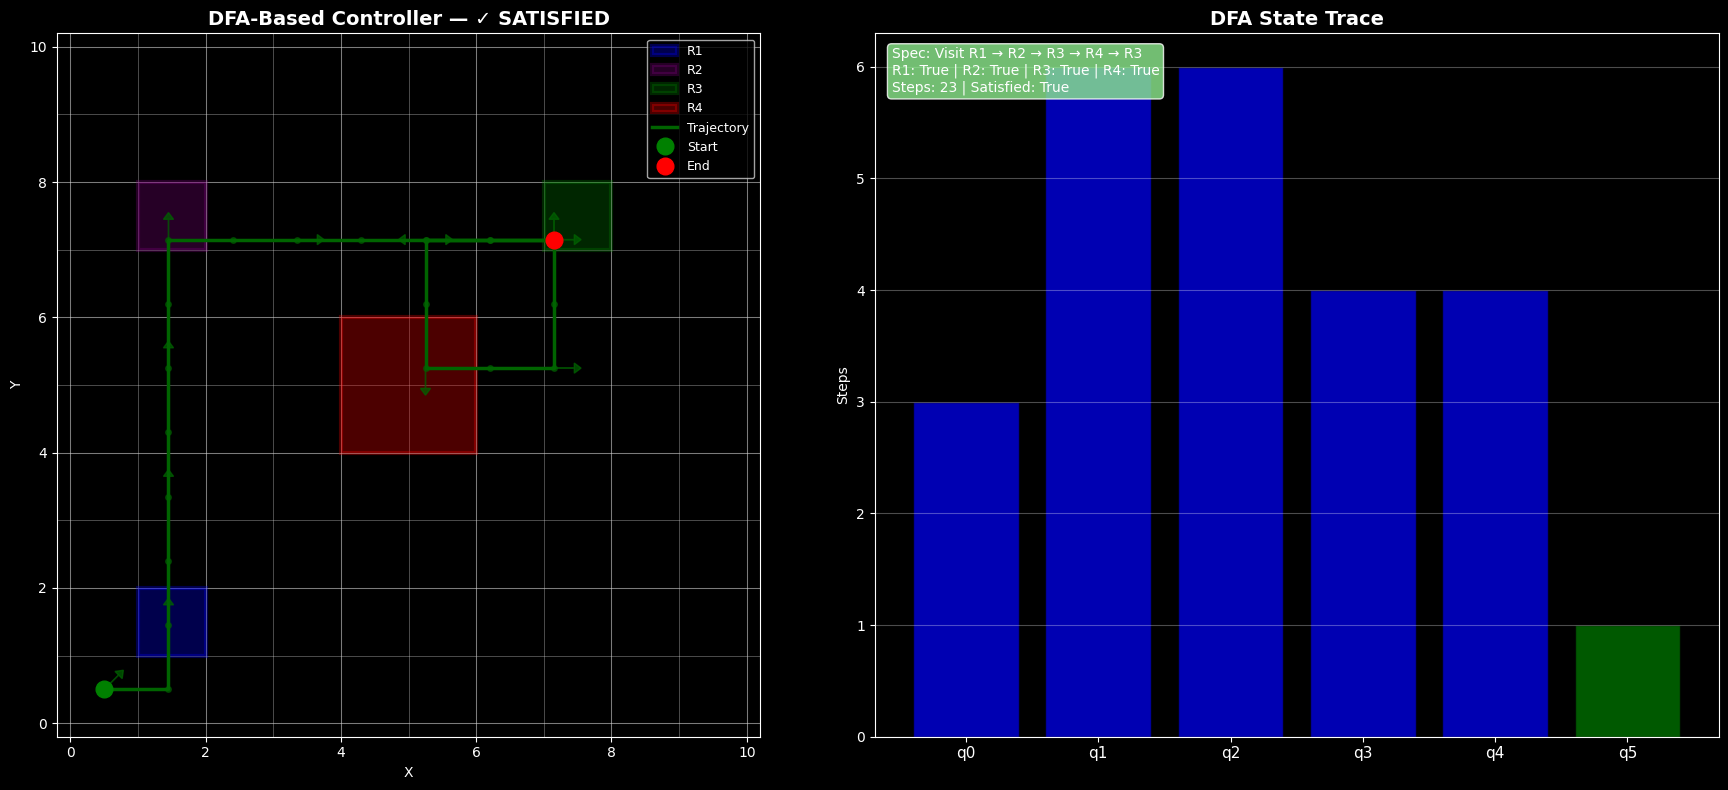

In [26]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from collections import deque

# ==========================
# Grid robot abstraction (NFA)
# ==========================

class MockRobot:
    def __init__(self):
        # 10x10 grid, each cell 1x1 over [0,10]x[0,10]
        x_edges = np.linspace(0, 10, 11)
        y_edges = np.linspace(0, 10, 11)
        theta_edges = np.array([0, 2 * np.pi])
        self.state_edges = [x_edges, y_edges, theta_edges]

        self.index_to_intervals = {}
        self.index_to_ij = {}
        self.ij_to_index = {}
        idx = 1
        for j in range(10):         # row (y)
            for i in range(10):     # col (x)
                self.index_to_intervals[idx] = (
                    (x_edges[i], x_edges[i+1]),
                    (y_edges[j], y_edges[j+1]),
                    (0, 2 * np.pi)
                )
                self.index_to_ij[idx] = (i, j)
                self.ij_to_index[(i, j)] = idx
                idx += 1

    def _find_state(self, x):
        x_pos, y_pos, theta = x
        x_pos = min(max(x_pos, 0.0), 9.999)
        y_pos = min(max(y_pos, 0.0), 9.999)
        i = int(np.floor(x_pos))
        j = int(np.floor(y_pos))
        return self.ij_to_index.get((i, j), -1)

    def find_indices_for_interval(self, bounds):
        # bounds: [[x_min, x_max], [y_min, y_max]]
        x_min, x_max = bounds[0]
        y_min, y_max = bounds[1]
        indices = []
        for idx, ((x0, x1), (y0, y1), _) in self.index_to_intervals.items():
            if x0 < x_max and x1 > x_min and y0 < y_max and y1 > y_min:
                indices.append(idx)
        return indices

    ACTIONS = ['E', 'W', 'N', 'S']
    DELTAS = {
        'E': (1, 0),
        'W': (-1, 0),
        'N': (0, 1),
        'S': (0, -1),
    }

    def get_successors(self, xi, action):
        """Deterministic neighbor for a grid action."""
        if xi == -1 or action not in self.ACTIONS:
            return []
        i, j = self.index_to_ij[xi]
        di, dj = self.DELTAS[action]
        ni, nj = i + di, j + dj
        if 0 <= ni < 10 and 0 <= nj < 10:
            return [self.ij_to_index[(ni, nj)]]
        return [xi]  # clamp to stay if outside

    def cell_center(self, xi):
        (x0, x1), (y0, y1), _ = self.index_to_intervals[xi]
        return (0.5 * (x0 + x1), 0.5 * (y0 + y1))

    def continuous_step(self, x, action):
        """Small continuous move for visualization aligned to action."""
        x_, y_, theta = x
        dt = 0.95
        speed = 1.0
        dx, dy = 0.0, 0.0
        if action == 'E':
            dx, dy = speed * dt, 0.0
            theta = 0.0
        elif action == 'W':
            dx, dy = -speed * dt, 0.0
            theta = np.pi
        elif action == 'N':
            dx, dy = 0.0, speed * dt
            theta = np.pi / 2
        elif action == 'S':
            dx, dy = 0.0, -speed * dt
            theta = -np.pi / 2
        return [x_ + dx, y_ + dy, theta]


# ==========================
# DFA for strict sequence R1 → R2 → R3 → R4 → R3
# ==========================

class DFA:
    def __init__(self):
        self.states = ['q0', 'q1', 'q2', 'q3', 'q4', 'q5', 'qfail']
        self.initial_state = 'q0'
        self.accepting_states = {'q5'}
        self.transitions = self._build()

    def _build(self):
        t = {}
        # q0: wait for R1; other stays; R2/R3/R4 -> fail
        t[('q0', 'R1')] = 'q1'
        t[('q0', 'other')] = 'q0'
        for r in ['R2', 'R3', 'R4']:
            t[('q0', r)] = 'qfail'
        # q1: after R1, wait for R2; R1/other stay; R3/R4 -> fail
        t[('q1', 'R2')] = 'q2'
        t[('q1', 'R1')] = 'q1'
        t[('q1', 'other')] = 'q1'
        for r in ['R3', 'R4']:
            t[('q1', r)] = 'qfail'
        # q2: after R2, wait for R3; R2/other stay; R1/R4 -> fail
        t[('q2', 'R3')] = 'q3'
        t[('q2', 'R2')] = 'q2'
        t[('q2', 'other')] = 'q2'
        for r in ['R1', 'R4']:
            t[('q2', r)] = 'qfail'
        # q3: after R3, wait for R4; R3/other stay; R1/R2 -> fail
        t[('q3', 'R4')] = 'q4'
        t[('q3', 'R3')] = 'q3'
        t[('q3', 'other')] = 'q3'
        for r in ['R1', 'R2']:
            t[('q3', r)] = 'qfail'
        # q4: after R4, wait for R3; R4/other stay; R1/R2 -> fail
        t[('q4', 'R3')] = 'q5'
        t[('q4', 'R4')] = 'q4'
        t[('q4', 'other')] = 'q4'
        for r in ['R1', 'R2']:
            t[('q4', r)] = 'qfail'
        # q5: accepting absorbing; qfail: absorbing failure
        for sym in ['R1', 'R2', 'R3', 'R4', 'other']:
            t[('q5', sym)] = 'q5'
            t[('qfail', sym)] = 'qfail'
        return t

    def step(self, q, symbol):
        return self.transitions.get((q, symbol), 'qfail')

    def visualize(self):
        print("\n=== DFA Structure ===")
        print(f"Initial: {self.initial_state}, Accepting: {self.accepting_states}")
        for (q, sym), qn in sorted(self.transitions.items()):
            if q in ['q0', 'q1', 'q2', 'q3', 'q4']:
                print(f"  {q} --[{sym}]--> {qn}")


# ==========================
# Augmented system (NFA × DFA)
# ==========================

class AugmentedSystem:
    def __init__(self, robot, dfa, R1_states, R2_states, R3_states, R4_states):
        self.robot = robot
        self.dfa = dfa
        self.R1 = set(R1_states)
        self.R2 = set(R2_states)
        self.R3 = set(R3_states)
        self.R4 = set(R4_states)

        self.augmented_states = []
        self.state_to_aug = {}
        self.aug_to_state = {}
        self.targets = set()
        self._build()

    def _build(self):
        print("\n=== Building Augmented System (Grid × DFA) ===")
        idx = 0
        for xi in range(1, 100 + 1):
            for q in self.dfa.states:
                s = (xi, q)
                self.augmented_states.append(s)
                self.state_to_aug[s] = idx
                self.aug_to_state[idx] = s
                if q in self.dfa.accepting_states:
                    self.targets.add(idx)
                idx += 1
        print(f"Augmented states: {len(self.augmented_states)} | Targets: {len(self.targets)}")

    def label(self, xi):
        if xi in self.R1: return 'R1'
        if xi in self.R2: return 'R2'
        if xi in self.R3: return 'R3'
        if xi in self.R4: return 'R4'
        return 'other'

    def successors(self, aug_idx, action):
        xi, q = self.aug_to_state[aug_idx]
        out = []
        for xn in self.robot.get_successors(xi, action):
            sym = self.label(xn)
            qn = self.dfa.step(q, sym)
            if qn == 'qfail':
                continue
            out.append(self.state_to_aug[(xn, qn)])
        return out


# ==========================
# Backward reachability and controller synthesis
# ==========================

class DFAReachabilityController:
    def __init__(self, aug):
        self.aug = aug
        self.R_star = None
        self.layers = []  # R^0, R^1, ...
        self.H = {}       # augmented index -> list of actions

    def actions(self):
        return ['E', 'W', 'N', 'S']

    def pre(self, R):
        A = self.actions()
        preS = set()
        for s in range(len(self.aug.augmented_states)):
            for a in A:
                succs = self.aug.successors(s, a)
                if any(t in R for t in succs):
                    preS.add(s)
                    break
        return preS

    def compute_R_star(self):
        print("\n=== Computing R* via backward reachability ===")
        R_prev = set(self.aug.targets)
        self.layers = [R_prev.copy()]  # layer 0: targets
        it = 0
        while True:
            it += 1
            R_new = set(self.aug.targets)
            R_new.update(self.pre(R_prev))
            self.layers.append(R_new.copy())
            if R_new == R_prev:
                break
            R_prev = R_new
            if it > 500:
                print("Warning: Max iterations reached.")
                break
        self.R_star = R_prev
        print(f"R* size: {len(self.R_star)}")
        return self.R_star

    def compute_controller(self):
        if self.R_star is None:
            self.compute_R_star()
        print("\n=== Synthesizing controller on R* ===")
        A = self.actions()
        for s in self.R_star:
            # earliest layer containing s
            k = None
            for i, Ri in enumerate(self.layers):
                if s in Ri:
                    k = i
                    break
            if k is None or k == 0:
                continue
            target_layer = self.layers[k - 1]
            valid = []
            for a in A:
                succs = self.aug.successors(s, a)
                if succs and any(t in target_layer for t in succs):
                    valid.append(a)
            if valid:
                self.H[s] = valid
        print(f"Controller states: {len(self.H)}")
        return self.H


# ==========================
# Simulation using only the synthesized controller
# ==========================

def run_simulation(robot, aug, ctrl, initial_state, steps=250):
    print("\n=== Running closed-loop simulation ===")
    traj = [initial_state]
    xi = robot._find_state(np.array(initial_state))
    q = aug.dfa.initial_state
    aug_idx = aug.state_to_aug[(xi, q)]

    dfa_trace = [q]
    spec_ok = False
    visited = {'R1': False, 'R2': False, 'R3': False, 'R4': False}

    def region_flags(xi_local):
        lab = aug.label(xi_local)
        if lab in visited:
            visited[lab] = True
        return lab

    for step in range(steps):
        # Update DFA with current region
        lab = region_flags(xi)
        q = aug.dfa.step(q, lab)
        dfa_trace.append(q)
        if q == 'qfail':
            print(f"❌ SPECIFICATION FAILED at step {step}")
            break
        if q in aug.dfa.accepting_states:
            spec_ok = True
            print(f"🎯 SPECIFICATION SATISFIED at step {step}!")
            break

        aug_idx = aug.state_to_aug[(xi, q)]

        # Choose action from controller; if missing, keep progress within R*
        if aug_idx in ctrl.H and ctrl.H[aug_idx]:
            a = ctrl.H[aug_idx][0]
        else:
            # Greedy fallback inside R*: choose any action whose successor stays in R*
            a = None
            for cand in ['E', 'W', 'N', 'S']:
                succs = aug.successors(aug_idx, cand)
                if any(s in ctrl.R_star for s in succs):
                    a = cand
                    break
            if a is None:
                a = 'E'  # last resort

        # Apply action
        x_cont = robot.continuous_step(traj[-1], a)
        traj.append(x_cont)
        xi = robot.get_successors(xi, a)[0]

        if step % 10 == 0:
            xc, yc = robot.cell_center(xi)
            print(f"Step {step}: cell={xi}, pos≈({xc:.2f},{yc:.2f}), DFA={q}, action={a}")

    return traj, dfa_trace, spec_ok, visited


# ==========================
# Visualization
# ==========================

def visualize(robot, traj, dfa_trace, spec_ok, visited, R1_bounds, R2_bounds, R3_bounds, R4_bounds):
    x = [s[0] for s in traj]
    y = [s[1] for s in traj]
    theta = [s[2] for s in traj]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    x_edges = robot.state_edges[0]
    y_edges = robot.state_edges[1]

    for xe in x_edges:
        ax1.axvline(x=xe, color='lightgray', linewidth=0.5, alpha=0.5)
    for ye in y_edges:
        ax1.axhline(y=ye, color='lightgray', linewidth=0.5, alpha=0.5)

    def draw_box(bounds, color, label):
        x_min, x_max = bounds[0]
        y_min, y_max = bounds[1]
        rect = patches.Rectangle(
            (x_min, y_min), x_max - x_min, y_max - y_min,
            linewidth=3, edgecolor=color, facecolor=color, alpha=0.3, label=label, zorder=2
        )
        ax1.add_patch(rect)

    draw_box(R1_bounds, 'blue', 'R1')
    draw_box(R2_bounds, 'purple', 'R2')
    draw_box(R3_bounds, 'green', 'R3')
    draw_box(R4_bounds, 'red', 'R4')

    traj_color = 'darkgreen' if spec_ok else 'orange'
    ax1.plot(x, y, color=traj_color, linewidth=2.5, label='Trajectory', zorder=3)
    ax1.plot(x, y, 'o', color=traj_color, markersize=4, alpha=0.6, zorder=4)

    arrow_interval = max(1, len(x)//8)
    for i in range(0, len(x), arrow_interval):
        dx = 0.3 * np.cos(theta[i]); dy = 0.3 * np.sin(theta[i])
        ax1.arrow(x[i], y[i], dx, dy, head_width=0.15, head_length=0.1,
                  fc=traj_color, ec=traj_color, alpha=0.7, zorder=5)

    ax1.plot(x[0], y[0], 'go', markersize=12, label='Start', zorder=6)
    ax1.plot(x[-1], y[-1], 'ro', markersize=12, label='End', zorder=6)

    ax1.set_title(f'DFA-Based Controller — {"✓ SATISFIED" if spec_ok else "✗ FAILED"}',
                  fontsize=14, fontweight='bold')
    ax1.set_xlabel('X'); ax1.set_ylabel('Y'); ax1.legend(fontsize=9, loc='upper right')
    ax1.set_aspect('equal'); ax1.grid(True, alpha=0.3)
    ax1.set_xlim(x_edges[0]-0.2, x_edges[-1]+0.2); ax1.set_ylim(y_edges[0]-0.2, y_edges[-1]+0.2)

    dfa_states_unique = list(dict.fromkeys(dfa_trace))
    steps_per_state = [dfa_trace.count(s) for s in dfa_states_unique]
    colors = ['green' if s in ['q5'] else ('red' if s=='qfail' else 'blue') for s in dfa_states_unique]
    ax2.bar(range(len(dfa_states_unique)), steps_per_state, color=colors, alpha=0.7, edgecolor='black')
    ax2.set_xticks(range(len(dfa_states_unique))); ax2.set_xticklabels(dfa_states_unique, fontsize=11)
    ax2.set_ylabel('Steps'); ax2.set_title('DFA State Trace', fontsize=14, fontweight='bold'); ax2.grid(True, alpha=0.3, axis='y')

    info = (
        f"Spec: Visit R1 → R2 → R3 → R4 → R3\n"
        f"R1: {visited['R1']} | R2: {visited['R2']} | R3: {visited['R3']} | R4: {visited['R4']}\n"
        f"Steps: {len(traj)} | Satisfied: {spec_ok}"
    )
    box_color = 'lightgreen' if spec_ok else 'lightcoral'
    ax2.text(0.02, 0.98, info, transform=ax2.transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor=box_color, alpha=0.8))

    plt.tight_layout()
    plt.show()


# ==========================
# Main: DFA → product with NFA → R* → controller → simulation
# ==========================

def main_dfa_controller():
    # Regions: single-cell boxes aligned to grid
    R1_bounds = [[1.0, 2.0], [1.0, 2.0]]   # cell (1,1)
    R2_bounds = [[1.0, 2.0], [7.0, 8.0]]   # cell (1,7)
    R3_bounds = [[7.0, 8.0], [7.0, 8.0]]   # cell (7,7)
    R4_bounds = [[4.0, 6.0], [4.0, 6.0]]   # 2x2 block center (acts like obstacle set)

    robot = MockRobot()

    R1_states = robot.find_indices_for_interval(R1_bounds)
    R2_states = robot.find_indices_for_interval(R2_bounds)
    R3_states = robot.find_indices_for_interval(R3_bounds)
    R4_states = robot.find_indices_for_interval(R4_bounds)

    print(f"R1 states: {len(R1_states)} | R2 states: {len(R2_states)} | R3 states: {len(R3_states)} | R4 states: {len(R4_states)}")

    dfa = DFA()
    dfa.visualize()

    aug = AugmentedSystem(robot, dfa, R1_states, R2_states, R3_states, R4_states)

    ctrl = DFAReachabilityController(aug)
    ctrl.compute_R_star()
    ctrl.compute_controller()

    # Start bottom-left corner, heading NE
    initial_state = [0.5, 0.5, np.pi/4]

    traj, dfa_trace, ok, visited = run_simulation(robot, aug, ctrl, initial_state, steps=250)

    visualize(robot, traj, dfa_trace, ok, visited, R1_bounds, R2_bounds, R3_bounds, R4_bounds)


if __name__ == "__main__":
    print("="*70)
    print("DFA × NFA Controller: Visit R1 → R2 → R3 → R4 → R3")
    print("="*70)
    main_dfa_controller()
